### Import packages

In [1]:
import time
import pickle
import itertools
import numpy as np
import pandas as pd
#import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from utilities import *

In [2]:
result_filename = 'model-02-build-keras-search-embedding_size'

### Params

In [3]:
is_log_target = True
is_per_area_target = True
is_embedding = True
is_tar_encoded = False
fix_town_and_city = False
rare_village_threshold = 2
rare_town_threshold = 2

map_target = {
    (True, True):   'log_per_area_total_price',
    (True, False):  'log_total_price',
    (False, True):  'per_area_total_price',
    (False, False): 'total_price'
}
col_target = map_target[(is_log_target, is_per_area_target)]
cols_num_add = ['land_per_building_area']
cols_cat_add = ['encoded_latlon']
cols_bin_add = []

#['day_in_year_txn_dt', 'day_in_year_building_complete_dt', 'dt_diff_building_complete_dt_txn_dt'] # dt num feats
#['dow_txn_dt', 'dow_building_complete_dt', 'month_txn_dt', 'month_building_complete_dt',
# 'quarter_txn_dt', 'quarter_building_complete_dt', 'year_txn_dt', 'year_building_complete_dt'] # dt cat feats

print('Target:', col_target)

Target: log_per_area_total_price


In [4]:
# Feature remove
# PARS #
N_feats_rm = 67
# PARS #

from vars_03 import score_base_per_area, shuffle_results_per_area

feat_imp = pd.DataFrame({'feats': shuffle_results_per_area[:,0],'avg':shuffle_results_per_area[:,1]})
feat_imp['diff'] = feat_imp['avg'] - score_base_per_area
feat_imp = feat_imp.sort_values(by='diff', ascending=False)
print(feat_imp.reset_index().values)

feats_rm = list(feat_imp.iloc[:(N_feats_rm+1)]['feats'].values)
feats_rm.remove('none')
print(len(feats_rm))
print(feats_rm)

[[0 5709.20035 'divorce_rate' 3.333296666667593]
 [1 5709.200316666666 'I_250' 3.333263333333889]
 [2 5708.200346666667 'XI_100' 2.33329333333495]
 [3 5707.867050000001 'VI_index_500' 1.9999966666682667]
 [4 5707.86704 'IX_index_50' 1.9999866666676098]
 [5 5707.866983333333 'VI_500' 1.9999300000008589]
 [6 5707.533710000001 'XIV_10' 1.666656666668132]
 [7 5707.200386666666 'XI_index_500' 1.3333333333339397]
 [8 5707.200383333334 'VI_index_1000' 1.3333300000012969]
 [9 5707.200373333333 'V_100' 1.33332000000064]
 [10 5707.200363333334 'VII_10' 1.333310000001802]
 [11 5707.200336666666 'X_100' 1.3332833333333838]
 [12 5706.867056666667 'XII_index_50' 1.0000033333344618]
 [15 5706.867050000001 'X_index_500' 0.9999966666682667]
 [14 5706.867050000001 'X_10' 0.9999966666682667]
 [13 5706.867050000001 'II_10' 0.9999966666682667]
 [16 5706.867046666666 'II_index_500' 0.9999933333338049]
 [17 5706.867046666666 'V_index_1000' 0.9999933333338049]
 [18 5706.867043333335 'XIII_10' 0.99999000000207

### Columns

In [5]:
cols_num = ['txn_dt', 'total_floor', 'building_complete_dt', 'parking_area', 'parking_price', 'txn_floor', 'land_area', 'building_area', 'lat', 'lon', 'village_income_median', 'town_population', 'town_area', 'town_population_density', 'doc_rate', 'master_rate', 'bachelor_rate', 'jobschool_rate', 'highschool_rate', 'junior_rate', 'elementary_rate', 'born_rate', 'death_rate', 'marriage_rate', 'divorce_rate', 'N_50', 'N_500', 'N_1000', 'N_5000', 'N_10000', 'I_10', 'I_50', 'I_100', 'I_250', 'I_500', 'I_1000', 'I_5000', 'I_10000', 'I_MIN', 'II_10', 'II_50', 'II_100', 'II_250', 'II_500', 'II_1000', 'II_5000', 'II_10000', 'II_MIN', 'III_10', 'III_50', 'III_100', 'III_250', 'III_500', 'III_1000', 'III_5000', 'III_10000', 'III_MIN', 'IV_10', 'IV_50', 'IV_100', 'IV_250', 'IV_500', 'IV_1000', 'IV_5000', 'IV_10000', 'IV_MIN', 'V_10', 'V_50', 'V_100', 'V_250', 'V_500', 'V_1000', 'V_5000', 'V_10000', 'V_MIN', 'VI_50', 'VI_100', 'VI_250', 'VI_500', 'VI_1000', 'VI_5000', 'VI_10000', 'VI_MIN', 'VII_10', 'VII_50', 'VII_100', 'VII_250', 'VII_500', 'VII_1000', 'VII_5000', 'VII_10000', 'VII_MIN', 'VIII_10', 'VIII_50', 'VIII_100', 'VIII_250', 'VIII_500', 'VIII_1000', 'VIII_5000', 'VIII_10000', 'VIII_MIN', 'IX_10', 'IX_50', 'IX_100', 'IX_250', 'IX_500', 'IX_1000', 'IX_5000', 'IX_10000', 'IX_MIN', 'X_10', 'X_50', 'X_100', 'X_250', 'X_500', 'X_1000', 'X_5000', 'X_10000', 'X_MIN', 'XI_10', 'XI_50', 'XI_100', 'XI_250', 'XI_500', 'XI_1000', 'XI_5000', 'XI_10000', 'XI_MIN', 'XII_10', 'XII_50', 'XII_100', 'XII_250', 'XII_500', 'XII_1000', 'XII_5000', 'XII_10000', 'XII_MIN', 'XIII_10', 'XIII_50', 'XIII_100', 'XIII_250', 'XIII_500', 'XIII_1000', 'XIII_5000', 'XIII_10000', 'XIII_MIN', 'XIV_10', 'XIV_50', 'XIV_100', 'XIV_250', 'XIV_500', 'XIV_1000', 'XIV_5000', 'XIV_10000', 'XIV_MIN']
cols_bin = ['I_index_50', 'I_index_500', 'I_index_1000', 'II_index_50', 'II_index_500', 'II_index_1000', 'III_index_50', 'III_index_500', 'III_index_1000', 'IV_index_50', 'IV_index_500', 'IV_index_1000', 'IV_index_5000', 'V_index_50', 'V_index_500', 'V_index_1000', 'VI_10', 'VI_index_50', 'VI_index_500', 'VI_index_1000', 'VII_index_50', 'VII_index_500', 'VII_index_1000', 'VIII_index_50', 'VIII_index_500', 'VIII_index_1000', 'IX_index_50', 'IX_index_500', 'IX_index_1000', 'IX_index_5000', 'X_index_50', 'X_index_500', 'X_index_1000', 'XI_index_50', 'XI_index_500', 'XI_index_1000', 'XI_index_5000', 'XI_index_10000', 'XII_index_50', 'XII_index_500', 'XII_index_1000', 'XIII_index_50', 'XIII_index_500', 'XIII_index_1000', 'XIII_index_5000', 'XIII_index_10000', 'XIV_index_50', 'XIV_index_500', 'XIV_index_1000']
cols_cat = ['building_material', 'city', 'building_type', 'building_use', 'parking_way', 'town', 'village']

print('Total (before remove):', 
      len(cols_num)+len(cols_bin)+len(cols_cat)+len(cols_num_add)+len(cols_bin_add)+len(cols_cat_add))

cols_num = [c for c in cols_num if c not in feats_rm]
cols_bin = [c for c in cols_bin if c not in feats_rm]
cols_cat = [c for c in cols_cat if c not in feats_rm]

# informational cols
cols_dt = ['txn_dt', 'building_complete_dt']

# right skew cols
#cols_right_skew = ['parking_area', 'land_area', 'building_area']+[c for c in cols_num if 'MIN' in c]

# For Stratified train test split
#cols_stratified = ['town', 'village']

print('Num:', len(cols_num), 'Bin:', len(cols_bin), 'Cat:', len(cols_cat))
print('Add:', len(cols_num_add), len(cols_bin_add), len(cols_cat_add), 
      'Total (after):', 
      len(cols_num)+len(cols_bin)+len(cols_cat)+len(cols_num_add)+len(cols_bin_add)+len(cols_cat_add))
#print('Right skew:', cols_right_skew)
#print('Total:', len(cols_feats))

Total (before remove): 213
Num: 130 Bin: 7 Cat: 7
Add: 1 0 1 Total (after): 146


### Read data

In [6]:
df = pd.read_csv('dataset/train.csv', dtype=object)
df.check()

,building_id,building_material,city,txn_dt,total_floor,building_type,building_use,building_complete_dt,parking_way,parking_area,...,XIV_500,XIV_index_500,XIV_1000,XIV_index_1000,XIV_5000,XIV_index_5000,XIV_10000,XIV_index_10000,XIV_MIN,total_price
0,e3mMIMR3JJqCaXz1,8,21,18674,4,3,2,6271,2,NaN,...,58,1,157,1,2483,1,6011,1,34.469802848528126,647603.7704719775
1,LgwzgklNvy4QCtq5,8,7,18800,5,1,2,7885,2,NaN,...,28,1,115,1,15872,1,32221,1,40.07357348973039,3321452.0
2,ucIR2NLLsC3T650L,8,7,19289,4,1,2,6028,2,NaN,...,78,1,212,1,15760,1,32228,1,54.46208108983661,9570885.316206373
3,jre1pJhcQj91Kdky,8,21,20385,24,0,2,18325,0,NaN,...,20,1,125,1,2568,1,7271,1,99.62896580763416,14215011.127100045
4,rQpYpY9nRG7X5mmr,1,21,20657,2,4,2,6880,2,NaN,...,18,1,47,1,2587,1,7442,1,124.1312362968124,762711.9757135696
59995,Oh5Hwr9LrWApC2mr,1,5,19040,2,4,2,9193,2,NaN,...,9,1,53,1,1435,1,4611,1,145.27967019169262,987021.4150420949
59996,PiOgZqfsDVlTq1zs,8,13,19706,14,2,5,17168,0,3.738411744735565,...,88,1,316,1,5659,1,22826,1,18.81499793345573,15725223.997450478
59997,FQmlgGohzzWuKUzu,8,7,19901,11,0,2,13729,0,NaN,...,113,1,348,1,13252,1,32687,1,94.79959334423607,11815402.03862225
59998,zjzfMwXhDswdEaI2,8,13,19975,5,1,2,7063,2,NaN,...,23,1,142,1,5317,1,21087,1,33.10458025153816,18084995.81999832
59999,iN4H6wBMtvJpF0SN,8,7,20385,5,1,2,8310,2,NaN,...,75,1,249,1,15417,1,32826,1,47.50987600102272,8510295.87633061


shape = (60000, 235)


### Preprocessing

In [7]:
def pre_processing(df, cols_num, cols_cat, cols_bin):
    """Preprocess (inplace) that are independent of train and validatoin set"""
    # Convert types
    df[cols_num] = df[cols_num].astype('float32')
    df[cols_bin] = df[cols_bin].astype('float32')
    df[cols_cat] = df[cols_cat].astype('int32')
    
    # target transform base (store this for inverse transform)
    if is_per_area_target:
        df['building_area_ori'] = df['building_area']
    
    # generate target
    if 'total_price' in df:
        df['total_price'] = df['total_price'].astype('float32')
        df['log_total_price'] = np.log1p(df['total_price'])
        df['per_area_total_price'] = df['total_price'] / df['building_area_ori']
        df['log_per_area_total_price'] = np.log1p(df['per_area_total_price'])
        df['target'] = df[col_target]

    # generate lat/lon encoded
    kmeans = pickle.load(open('./object_kmeans_k6_combined.pkl', 'rb'))
    df['encoded_latlon'] = kmeans.predict(df[['lat','lon']])
    
    # generate dt feats
    df = create_dt_feats(df, 'txn_dt')
    df = create_dt_feats(df, 'building_complete_dt')
    df['dt_diff_building_complete_dt_txn_dt'] = df['txn_dt'] - df['building_complete_dt']
    
    # generate building to land ratio
    df['land_per_building_area'] = df['land_area'] / df['building_area']
    
    # fix town and city
    if fix_town_and_city:
        df['town'] = df['city'].astype('str')+'-'+df['town'].astype('str')
        df['village'] = df['town'].astype('str')+'-'+df['village'].astype('str')
    
    return df

In [8]:
def post_processing(y_pred, df):
    """Post processing target
       Args: 
          y_pred (1d np.array): raw prediction y
          df (pd.Dataframe): input feature df
       Return: np.array
    """
    y_pred_final = y_pred.copy()
    
    if is_log_target:
        y_pred_final = np.expm1(y_pred_final)
        y_pred_final = np.clip(y_pred_final, 0, None)

    if is_per_area_target:
        y_pred_final = y_pred_final * df['building_area_ori'].values
        
    return y_pred_final

In [9]:
df = pre_processing(df, cols_num, cols_cat, cols_bin)

/home/louis.yang.925/.local/lib/python3.5/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator KMeans from version 0.20.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [10]:
# Add those added feature columns (run this after preprocess has done)
cols_num = cols_num + [c for c in cols_num_add if c not in cols_num]
cols_cat = cols_cat + [c for c in cols_cat_add if c not in cols_cat]
cols_bin = cols_bin + [c for c in cols_bin_add if c not in cols_bin]
cols_feats = cols_num + cols_cat + cols_bin
print('Feat columns:', cols_feats)

# Target mean encoded columns
cols_tar_encoded = ['encoded_'+c for c in cols_cat] if is_tar_encoded else []
    
print('\nTarget mean encoded columns:', cols_tar_encoded)

# Compute skew columns
cols_right_skew = [c for c in cols_num if df[c].skew() > 2.2]
print('\nRight skew columns:', cols_right_skew)

# Fillna values for null columns
fillna_values = {
    'parking_area': -1.,
    'parking_price': -1.,
    'txn_floor': 0.,
    #'village_income_median': 'median',
}

Feat columns: ['txn_dt', 'total_floor', 'building_complete_dt', 'parking_area', 'parking_price', 'txn_floor', 'land_area', 'building_area', 'lat', 'lon', 'village_income_median', 'town_population', 'town_area', 'town_population_density', 'doc_rate', 'master_rate', 'bachelor_rate', 'jobschool_rate', 'highschool_rate', 'junior_rate', 'elementary_rate', 'born_rate', 'death_rate', 'marriage_rate', 'N_50', 'N_1000', 'N_5000', 'N_10000', 'I_1000', 'I_5000', 'I_10000', 'I_MIN', 'II_100', 'II_250', 'II_500', 'II_1000', 'II_5000', 'II_10000', 'II_MIN', 'III_10', 'III_50', 'III_100', 'III_250', 'III_500', 'III_1000', 'III_5000', 'III_10000', 'III_MIN', 'IV_10', 'IV_100', 'IV_250', 'IV_500', 'IV_1000', 'IV_5000', 'IV_10000', 'IV_MIN', 'V_50', 'V_250', 'V_500', 'V_1000', 'V_5000', 'V_10000', 'V_MIN', 'VI_5000', 'VI_10000', 'VI_MIN', 'VII_50', 'VII_100', 'VII_250', 'VII_500', 'VII_1000', 'VII_5000', 'VII_10000', 'VII_MIN', 'VIII_10', 'VIII_50', 'VIII_100', 'VIII_250', 'VIII_500', 'VIII_1000', 'VIII

### Feature engineering
Include cat encoding, fillna, scaling

In [11]:
from feature_engineering import CategoricalColumnsEncoder
from feature_engineering import TargetMeanEncoding
from feature_engineering import MultiLabelEncoding
from feature_engineering import PdStandardScaler, PdMedianScaler, PdMinMaxScaler

In [12]:
class FeatureEngineering():
    def __init__(self, cols_num, cols_cat, cols_bin, col_target, 
                 fillna_values={}, cols_right_skew=[], is_embedding=False, is_tar_encoded=True,
                 n_ran_encode=4, rare_village_threshold=2, rare_town_threshold=2):
        # Cols
        self.cols_num = cols_num
        self.cols_cat = cols_cat
        self.cols_bin = cols_bin
        self.col_target = col_target
        self.cols_right_skew = cols_right_skew
        
        # Numbers
        #self.n_ran_encode = n_ran_encode
        
        # Rare village and town
        self.rare_town_threshold = rare_town_threshold
        self.rare_village_threshold = rare_village_threshold
        
        # Cat encoders
        self.is_tar_encoded = is_tar_encoded
        if is_tar_encoded:
            self.tar_encoder = TargetMeanEncoding(col_target = self.col_target)
        #self.ran_encoder = MultiLabelEncoding(self.n_ran_encode)
        self.is_embedding = is_embedding
        if is_embedding:
            self.cat_astyper = CategoricalColumnsEncoder(mode='keras', reserve_missing=True)
        
        # Fillna
        self.fillna_values = fillna_values
        
        # Skewness
        self.mins_right_skew_cols = {}  # map from the col name to the original min
        
        # Normalization
        self.scaler = PdStandardScaler()
        
        # Target normalization
        self.target_scaler = PdStandardScaler()
        
    def fit_transform(self, df, df_test):
        df = df.copy()   
        
        # Rare village and town
        train_towns = df['town'].value_counts()
        rare_towns = (set(train_towns.index[train_towns <= self.rare_town_threshold])
                      - set(df_test['town']))
        df.loc[df['town'].isin(rare_towns), 'town'] = np.nan
        
        train_villages = df['village'].value_counts()        
        rare_villages = (set(train_villages.index[train_villages <= self.rare_village_threshold])
                         - set(df_test['village']))
        df.loc[df['village'].isin(rare_villages), 'village'] = np.nan
        
        # Cat encoders
        if self.is_tar_encoded:
            df_tar_encoded = self.tar_encoder.fit_transform(df[self.cols_cat], df[self.col_target])
            self.cols_tar_encoded = [c for c in df_tar_encoded]
            for c in df_tar_encoded:
                df[c] = df_tar_encoded[c].astype('float32')
        else:
            self.cols_tar_encoded = []
        #encoded2 = self.ran_encoder.fit_transform(df[self.cols_cat])
        if self.is_embedding:
            self.cat_astyper.fit_transform(df, self.cols_cat)
        
        # Fillna
        self.fillna_values['village_income_median'] = df['village_income_median'].median()
        for c, v in self.fillna_values.items():
            df[c] = df[c].fillna(v)
    
        # Skewness
        for c in self.cols_right_skew:
            # if the minimum of the col < 0, then subtract the min first (to make it positive)
            self.mins_right_skew_cols[c] = min(df[c].min(), 0)
            df[c] = np.log10(0.1 + df[c] - self.mins_right_skew_cols[c]).astype('float32')
    
        # Normalization
        self.scaler.fit(df, cols=self.cols_num+self.cols_tar_encoded)
        self.scaler.transform(df)  # transform inplace!
        
        # Target normalization
        assert self.col_target in df, 'Target column not found in the dataframe'
        self.target_scaler.fit(df, cols=[self.col_target])
        self.target_scaler.transform(df, cols_input=[self.col_target], cols_transformed=[self.col_target+'_scaled'])
        
        return df
        #return pd.concat([df, encoded1, encoded2], axis=1)
    
    def transform(self, df):
        df = df.copy()
        # Cat encoders
        if self.is_tar_encoded:
            df_tar_encoded = self.tar_encoder.transform(df[self.cols_cat])
            for c in df_tar_encoded:
                df[c] = df_tar_encoded[c].astype('float32')
        #encoded2 = self.ran_encoder.transform(df[self.cols_cat])     # TODO: add generated feats into cols_feats
        if self.is_embedding:
            self.cat_astyper.transform(df)
    
        # Fillna
        for c, v in self.fillna_values.items():
            df[c] = df[c].fillna(v)    

        # Skewness
        for c in self.cols_right_skew:
            df[c] = np.log10(0.1 + df[c] - self.mins_right_skew_cols[c]).astype('float32')
        
        # Normalization
        self.scaler.transform(df)  # transform inplace!
        
        # Target normalization
        if self.col_target in df:
            self.target_scaler.transform(df, cols_input=[self.col_target], cols_transformed=[self.col_target+'_scaled'])
        
        return df
        #return pd.concat([df, encoded1, encoded2], axis=1)
        
    def target_inverse_transform(self, df, col_scaled_target, col_unscaled_target):
        self.target_scaler.inverse_transform(df, cols_input=[col_scaled_target], 
                                             cols_transformed=[col_unscaled_target])
        return df[col_unscaled_target]

### Keras Model

In [3]:
import keras
import tensorflow as tf
print('keras:', keras.__version__, 'tensorflow:', tf.__version__)

from keras.models import Model
from keras.layers import Input, Dense, Embedding, Flatten, Reshape, concatenate, Dropout, BatchNormalization, Activation, Add
from keras.optimizers import Adam, SGD

Using TensorFlow backend.


keras: 2.2.4 tensorflow: 1.14.0


In [4]:
from keras_get_best import GetBest
from keras_SGDRScheduler import SGDRScheduler

In [5]:
def build_model(n_cols_num_bin, cat_n_classes={}, cat_embed_sizes={}, 
                n_neurons=(1024,)*10, learning_rate=0.001, optimizer=Adam, loss='mse', 
                skip_connection=False, batch_norm=False, activation='relu', dropout=0.,
                **ignored):
    '''Args: 
       n_cols_num_bin: number of numerical and binary features
       cat_n_classes: dict of cat column name to number of classes in the cat column
       cat_embed_sizes: dict of cat column name to embedding output size
       n_neurons: list of number of neurons for each dense layer
    '''
    if skip_connection:
        assert all([x==n_neurons[0] for x in n_neurons]), 'Residual connection only work' \
            ' for square shape network'
    is_embedding = len(cat_n_classes) > 0
    num_bin_input = Input(shape=(n_cols_num_bin,), dtype='float32', name='num_bin')
    cats_inputs = {c: Input(shape=(1,), dtype='int32', name=c) for c in cat_n_classes}
    if is_embedding:
        cats_embedding_layers = [
            Reshape(target_shape=(cat_embed_sizes[c],))(
                Embedding(input_dim=c_input_dim, output_dim=cat_embed_sizes[c])(cats_inputs[c])
            ) 
            for c, c_input_dim in cat_n_classes.items()
        ]
        x_layer = concatenate([num_bin_input]+cats_embedding_layers)  # output shape = 258
    else:
        x_layer = num_bin_input
    for i, n in enumerate(n_neurons):
        if skip_connection and i%2 == 1:
            skip_layer = x_layer
        x_layer = Dense(n)(x_layer)
        x_layer = Activation(activation)(x_layer)
        if dropout > 0. and i < len(n_neurons)-1:
            x_layer = Dropout(dropout)(x_layer)
        if batch_norm:
            x_layer = BatchNormalization()(x_layer)
        if skip_connection and i%2 == 0 and i > 0:
            x_layer = Add()([x_layer, skip_layer])
    output = Dense(1)(x_layer)
    model = Model(inputs=[num_bin_input]+list(cats_inputs.values()),
                  outputs=output)
    metrics = [m for m in ['mse', 'mae'] if m != loss]
    model.compile(optimizer=optimizer(lr=learning_rate), loss=loss, metrics=metrics)
    return model    

def build_features_matrices(df, cols_num, cols_cat, cols_bin):
    Xs = {'num_bin': df[cols_num+cols_bin].values}
    for c in cols_cat:
        Xs[c] = df[c].values
    return Xs

def plot_keras_hist(hists, ylim=None, metrics_plot=None, labels=None):
    if not isinstance(hists, list): hists=[hists]
    if metrics_plot is None:
        metrics_plot = [c for c in hists[0].history.keys() if not c.startswith('val')]
    if labels is None:
        labels = [str(i) for i in range(len(hists))]
    for m in metrics_plot:
        plt.figure(figsize=(14, 4))
        for label, hist in zip(labels, hists):
            for c in hist.history:
                if c.endswith(m):
                    plt.plot(hist.history[c], label=c+' '+label, alpha=0.9)
        if ylim != None:
            plt.ylim(*ylim)
        plt.xlabel('epochs'); plt.title(m)
        plt.legend(); plt.grid(); plt.show()

def plot_list_hist(hists, ylim=None, metrics_plot=None, labels=None):
    if not isinstance(hists, list): hists=[hists]
    if metrics_plot is None:
        metrics_plot = [c for c in hists[0].keys() if not c.startswith('val')]
    if labels is None:
        labels = [str(i) for i in range(len(hists))]
    for m in metrics_plot:
        plt.figure(figsize=(14, 4))
        for label, hist in zip(labels, hists):
            for c in hist:
                if c.endswith(m):
                    plt.plot(hist[c], label=c+' '+label, alpha=0.9)
        if ylim != None:
            plt.ylim(*ylim)
        plt.xlabel('epochs'); plt.title(m)
        plt.legend(); plt.grid(); plt.show()

def plot_list_hist_mean(hists, ylim=None, metrics_plot=None):
    if not isinstance(hists, list): hists=[hists]
    if metrics_plot is None:
        metrics_plot = [c for c in hists[0].keys() if not c.startswith('val')]
    keys_plot = [c for c in hists[0] for m in metrics_plot if c.endswith(m)]
    
    for c in keys_plot:
        plt.figure(figsize=(14, 4))
        array = np.zeros((len(hists[0][c]), len(hists)))
        for i, hist in enumerate(hists):
            array[:, i] = np.array(hist[c])
        sq_mean = array.mean(axis=1)
        sq_std = np.std(array, axis=1)
        #plt.errorbar(np.arange(1, len(sq_mean)+1), sq_mean, yerr=sq_std, label=c, alpha=0.9, fmt='-o')
        plt.plot(sq_mean, label=c+'_mean')
        plt.plot(sq_mean+sq_std, label=c+'_std+', alpha=0.5)
        plt.plot(sq_mean-sq_std, label=c+'_std-', alpha=0.5)
        if ylim != None: plt.ylim(*ylim)
        plt.xlabel('epochs'); plt.title(c+'_mean')
        plt.legend(); plt.grid(); plt.show()

### Compute N of parameters

In [17]:
def n_params(n_neurons, n_inputs=194):
    """ Compute N of parameters for the dense layers """
    n_params = n_neurons[0]*(n_inputs+1)
    for i in range(1, len(n_neurons)):
        n_params += (n_neurons[i-1]+1)*n_neurons[i]
    n_params += (n_neurons[-1]+1)
    return n_params

def solve_2nd_order_equation(a, b, c):
    """ Solve a*x^2 +b*x + c == 0 for x """
    return (-b+np.sqrt(b**2 - 4*a*c)) / (2*a) 

def solve_width_for_ratio(ratios, params, n_inputs=194):
    """ Solve the width given ratio for each layers and the total params.
        Assume the layers to be (width*ratios[0], width*ratios[1], width*ratios[2], ...)
    """
    b = ratios[0]*(n_inputs+1)
    a = 0
    for i in range(1, len(ratios)):
        a += ratios[i-1]*ratios[i]
        b += ratios[i]
    b += ratios[-1]
    c = 1 - params
    #print(a, b, c)
    return solve_2nd_order_equation(a, b, c)

def best_n_neurons(ratios, params, n_inputs=194):
    width = int(round(solve_width_for_ratio(ratios, params, n_inputs)))
    return tuple([width*x for x in ratios])

In [18]:
print(best_n_neurons(ratios=(4,4,2,2,1,1), params=9647105, n_inputs=194))

(2180, 2180, 1090, 1090, 545, 545)


### Grid search

In [19]:
# grid search
params_fix = {'epochs': 500,
              'loss': 'mse',
              'batch_norm': True,
              'n_neurons': (2180, 2180, 1090, 1090, 545, 545),
              'batch_size': 256,
             }

# prvs baseline best estimator
# 5524.863045737181,
# [5528.862755759428, 5530.862894274216, 5514.863487177898]]

params_gsearch = {
    #'learning_rate': [0.0009, 0.001, 0.0012],
    'embedding_ratio': [2, 3, 4, 5]
}
N_fold = 3
N_iter = 4
score_low_bound = 5000 # if score smaller than this, skip the param set

#### Round 1

In [20]:
# Round 1
rand_params_set = []
for i in range(N_iter):
    params_rand = {key: np.random.choice(params_gsearch[key]) for key in params_gsearch}
    while params_rand in rand_params_set:
        params_rand = {key: np.random.choice(params_gsearch[key]) for key in params_gsearch}
    rand_params_set.append(params_rand)

In [21]:
rand_params_set

[{'embedding_ratio': 2},
 {'embedding_ratio': 5},
 {'embedding_ratio': 3},
 {'embedding_ratio': 4}]

In [23]:
t0 = time.time()
gsearch = {}
folds = KFold(n_splits=N_fold, shuffle=True, random_state=123)
for i_fold, (itrain, ival) in enumerate(folds.split(df)): # kfold
    print('==== Fold', i_fold+1, '====')
    
    # split train, val
    df_train = df.loc[itrain].reset_index(drop=True)
    df_val = df.loc[ival].reset_index(drop=True)

    # feat eng
    feat_eng = FeatureEngineering(cols_num=cols_num, 
                                  cols_cat=cols_cat, 
                                  cols_bin=cols_bin, 
                                  col_target=col_target, 
                                  fillna_values=fillna_values, 
                                  cols_right_skew=cols_right_skew,
                                  is_embedding=is_embedding, 
                                  is_tar_encoded=is_tar_encoded,
                                  rare_village_threshold=rare_village_threshold, 
                                  rare_town_threshold=rare_town_threshold,)
    df_train = feat_eng.fit_transform(df_train, df_val)
    df_val = feat_eng.transform(df_val)

    # Prepare X y matrices
    if is_embedding:
        X_train = build_features_matrices(df_train, cols_num=cols_num+cols_tar_encoded, cols_cat=cols_cat, cols_bin=cols_bin)
        X_val = build_features_matrices(df_val, cols_num=cols_num+cols_tar_encoded, cols_cat=cols_cat, cols_bin=cols_bin)
    else:
        X_train = build_features_matrices(df_train, cols_num=cols_num+cols_tar_encoded, cols_cat=[], cols_bin=cols_bin)
        X_val = build_features_matrices(df_val, cols_num=cols_num+cols_tar_encoded, cols_cat=[], cols_bin=cols_bin)
    y_train = df_train[col_target+'_scaled']
    y_val = df_val[col_target+'_scaled']
    
    # random sample - grid search
    rand_params_next = []
    for i_set, params_rand in enumerate(rand_params_set):
        print('---', i_set+1, '/', len(rand_params_set), '---')
        params = params_fix.copy()
        params.update( params_rand )
        
        # Compute network size
        n_cols_num_bin = len(cols_num+cols_bin+cols_tar_encoded)
        if is_embedding:
            cat_n_classes = {c: feat_eng.cat_astyper.cat_n_classes[c] for c in cols_cat}
            cat_embed_sizes = {c: min(int(params['embedding_ratio']*np.log(cat_n_classes[c]+1)+1), 
                                      cat_n_classes[c]) for c in cat_n_classes}
        else:
            cat_n_classes = {}
            cat_embed_sizes = {}
        print('Numerical input dims:', n_cols_num_bin)
        print('Embeding  input dims:', cat_n_classes)
        print('Embeding output dims:', cat_embed_sizes)
        print('Total embedding output dims:', np.sum(list(cat_embed_sizes.values())))
        print()
    
        model = build_model(n_cols_num_bin, cat_n_classes, cat_embed_sizes, **params)

        hist = model.fit(x=X_train, y=y_train, verbose=2, validation_data=(X_val, y_val), 
                         callbacks=[GetBest(monitor='val_mean_absolute_error', verbose=0, mode='min')], 
                         batch_size=params['batch_size'], epochs=params['epochs'])

        df_val[col_target+'_scaled_pred'] = model.predict(X_val, batch_size=1024)

        feat_eng.target_inverse_transform(df_val, col_target+'_scaled_pred', col_target+'_pred')
        df_val['total_price_pred'] = post_processing(df_val[col_target+'_pred'], df_val)
        
        mse = mean_squared_error(df_val[col_target], df_val[col_target+'_pred'])
        mae = mean_absolute_error(df_val[col_target], df_val[col_target+'_pred'])
        mape = cal_mape(df_val[col_target], df_val[col_target+'_pred'])
        score = cal_score(df_val['total_price'], df_val['total_price_pred'])
        print('params:', params)
        print('score, mse, mae, mape: %.5f, %.5f, %.5f, %.5f' % (score, mse, mae, mape))

        if score < score_low_bound:
            continue

        rand_params_next.append(params_rand)
        tuple_params = tuple(params.items())
        if tuple_params not in gsearch:
            gsearch[tuple_params] = [[], [], [], [], []]
        gsearch[tuple_params][0].append(hist)
        gsearch[tuple_params][1].append(score)
        gsearch[tuple_params][2].append(mse)
        gsearch[tuple_params][3].append(mae)
        gsearch[tuple_params][4].append(mape)
        
    rand_params_set = rand_params_next
# aggregate, sort gsearch results
gsearch_results = [[key, *[np.mean(val_i) for val_i in val[1:]], *val] 
                   for key, val in gsearch.items()]
gsearch_results.sort(key= lambda x: x[1], reverse=True)
t1 = time.time()

==== Fold 1 ====


W0706 18:26:26.986807 140497685931776 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0706 18:26:27.009314 140497685931776 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0706 18:26:27.010748 140497685931776 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



--- 1 / 4 ---
Numerical input dims: 138
Embeding  input dims: {'building_material': 10, 'village': 2494, 'building_type': 6, 'building_use': 11, 'parking_way': 4, 'encoded_latlon': 7, 'town': 205, 'city': 12}
Embeding output dims: {'building_material': 5, 'village': 16, 'building_type': 4, 'building_use': 5, 'parking_way': 4, 'encoded_latlon': 5, 'town': 11, 'city': 6}
Total embedding output dims: 56



W0706 18:26:27.229574 140497685931776 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0706 18:26:27.886033 140497685931776 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0706 18:26:28.964771 140497685931776 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 40000 samples, validate on 20000 samples
Epoch 1/500
 - 8s - loss: 0.5284 - mean_absolute_error: 0.4038 - val_loss: 0.1458 - val_mean_absolute_error: 0.2900
Epoch 2/500
 - 6s - loss: 0.1163 - mean_absolute_error: 0.2586 - val_loss: 0.0934 - val_mean_absolute_error: 0.2301
Epoch 3/500
 - 6s - loss: 0.0921 - mean_absolute_error: 0.2301 - val_loss: 0.1012 - val_mean_absolute_error: 0.2448
Epoch 4/500
 - 6s - loss: 0.0793 - mean_absolute_error: 0.2132 - val_loss: 0.1019 - val_mean_absolute_error: 0.2495
Epoch 5/500
 - 6s - loss: 0.0710 - mean_absolute_error: 0.2013 - val_loss: 0.0790 - val_mean_absolute_error: 0.2082
Epoch 6/500
 - 6s - loss: 0.0633 - mean_absolute_error: 0.1904 - val_loss: 0.0669 - val_mean_absolute_error: 0.1878
Epoch 7/500
 - 6s - loss: 0.0595 - mean_absolute_error: 0.1838 - val_loss: 0.0763 - val_mean_absolute_error: 0.2064
Epoch 8/500
 - 6s - loss: 0.0555 - mean_absolute_error: 0.1782 - val_loss: 0.0830 - val_mean_absolute_error: 0.2144
Epoch 9/500
 - 6s - lo

Epoch 71/500
 - 6s - loss: 0.0196 - mean_absolute_error: 0.1041 - val_loss: 0.0660 - val_mean_absolute_error: 0.1782
Epoch 72/500
 - 6s - loss: 0.0171 - mean_absolute_error: 0.0983 - val_loss: 0.0649 - val_mean_absolute_error: 0.1782
Epoch 73/500
 - 6s - loss: 0.0159 - mean_absolute_error: 0.0955 - val_loss: 0.0698 - val_mean_absolute_error: 0.1855
Epoch 74/500
 - 6s - loss: 0.0175 - mean_absolute_error: 0.1005 - val_loss: 0.0654 - val_mean_absolute_error: 0.1785
Epoch 75/500
 - 6s - loss: 0.0172 - mean_absolute_error: 0.0993 - val_loss: 0.0594 - val_mean_absolute_error: 0.1661
Epoch 76/500
 - 6s - loss: 0.0166 - mean_absolute_error: 0.0971 - val_loss: 0.0636 - val_mean_absolute_error: 0.1751
Epoch 77/500
 - 6s - loss: 0.0177 - mean_absolute_error: 0.1006 - val_loss: 0.0637 - val_mean_absolute_error: 0.1770
Epoch 78/500
 - 6s - loss: 0.0164 - mean_absolute_error: 0.0967 - val_loss: 0.0613 - val_mean_absolute_error: 0.1747
Epoch 79/500
 - 6s - loss: 0.0151 - mean_absolute_error: 0.0924 

Epoch 141/500
 - 6s - loss: 0.0094 - mean_absolute_error: 0.0737 - val_loss: 0.0543 - val_mean_absolute_error: 0.1568
Epoch 142/500
 - 6s - loss: 0.0082 - mean_absolute_error: 0.0688 - val_loss: 0.0553 - val_mean_absolute_error: 0.1584
Epoch 143/500
 - 6s - loss: 0.0093 - mean_absolute_error: 0.0735 - val_loss: 0.0549 - val_mean_absolute_error: 0.1583
Epoch 144/500
 - 6s - loss: 0.0087 - mean_absolute_error: 0.0706 - val_loss: 0.0601 - val_mean_absolute_error: 0.1652
Epoch 145/500
 - 6s - loss: 0.0092 - mean_absolute_error: 0.0733 - val_loss: 0.0554 - val_mean_absolute_error: 0.1594
Epoch 146/500
 - 6s - loss: 0.0085 - mean_absolute_error: 0.0706 - val_loss: 0.0547 - val_mean_absolute_error: 0.1561
Epoch 147/500
 - 6s - loss: 0.0085 - mean_absolute_error: 0.0703 - val_loss: 0.0535 - val_mean_absolute_error: 0.1544
Epoch 148/500
 - 6s - loss: 0.0075 - mean_absolute_error: 0.0659 - val_loss: 0.0537 - val_mean_absolute_error: 0.1544
Epoch 149/500
 - 6s - loss: 0.0092 - mean_absolute_error

Epoch 211/500
 - 6s - loss: 0.0061 - mean_absolute_error: 0.0594 - val_loss: 0.0549 - val_mean_absolute_error: 0.1583
Epoch 212/500
 - 6s - loss: 0.0059 - mean_absolute_error: 0.0594 - val_loss: 0.0532 - val_mean_absolute_error: 0.1534
Epoch 213/500
 - 6s - loss: 0.0059 - mean_absolute_error: 0.0599 - val_loss: 0.0521 - val_mean_absolute_error: 0.1509
Epoch 214/500
 - 6s - loss: 0.0070 - mean_absolute_error: 0.0655 - val_loss: 0.0533 - val_mean_absolute_error: 0.1527
Epoch 215/500
 - 6s - loss: 0.0061 - mean_absolute_error: 0.0603 - val_loss: 0.0544 - val_mean_absolute_error: 0.1539
Epoch 216/500
 - 6s - loss: 0.0058 - mean_absolute_error: 0.0591 - val_loss: 0.0529 - val_mean_absolute_error: 0.1520
Epoch 217/500
 - 6s - loss: 0.0059 - mean_absolute_error: 0.0586 - val_loss: 0.0567 - val_mean_absolute_error: 0.1576
Epoch 218/500
 - 6s - loss: 0.0064 - mean_absolute_error: 0.0619 - val_loss: 0.0519 - val_mean_absolute_error: 0.1499
Epoch 219/500
 - 6s - loss: 0.0056 - mean_absolute_error

Epoch 281/500
 - 6s - loss: 0.0058 - mean_absolute_error: 0.0581 - val_loss: 0.0523 - val_mean_absolute_error: 0.1498
Epoch 282/500
 - 6s - loss: 0.0055 - mean_absolute_error: 0.0576 - val_loss: 0.0524 - val_mean_absolute_error: 0.1506
Epoch 283/500
 - 6s - loss: 0.0051 - mean_absolute_error: 0.0541 - val_loss: 0.0528 - val_mean_absolute_error: 0.1517
Epoch 284/500
 - 6s - loss: 0.0059 - mean_absolute_error: 0.0605 - val_loss: 0.0523 - val_mean_absolute_error: 0.1503
Epoch 285/500
 - 6s - loss: 0.0065 - mean_absolute_error: 0.0622 - val_loss: 0.0530 - val_mean_absolute_error: 0.1527
Epoch 286/500
 - 6s - loss: 0.0056 - mean_absolute_error: 0.0571 - val_loss: 0.0526 - val_mean_absolute_error: 0.1497
Epoch 287/500
 - 6s - loss: 0.0050 - mean_absolute_error: 0.0542 - val_loss: 0.0523 - val_mean_absolute_error: 0.1494
Epoch 288/500
 - 6s - loss: 0.0052 - mean_absolute_error: 0.0576 - val_loss: 0.0522 - val_mean_absolute_error: 0.1497
Epoch 289/500
 - 6s - loss: 0.0048 - mean_absolute_error

Epoch 351/500
 - 6s - loss: 0.0052 - mean_absolute_error: 0.0555 - val_loss: 0.0531 - val_mean_absolute_error: 0.1498
Epoch 352/500
 - 6s - loss: 0.0061 - mean_absolute_error: 0.0603 - val_loss: 0.0535 - val_mean_absolute_error: 0.1518
Epoch 353/500
 - 6s - loss: 0.0049 - mean_absolute_error: 0.0542 - val_loss: 0.0537 - val_mean_absolute_error: 0.1514
Epoch 354/500
 - 6s - loss: 0.0045 - mean_absolute_error: 0.0514 - val_loss: 0.0534 - val_mean_absolute_error: 0.1518
Epoch 355/500
 - 6s - loss: 0.0045 - mean_absolute_error: 0.0528 - val_loss: 0.0526 - val_mean_absolute_error: 0.1495
Epoch 356/500
 - 6s - loss: 0.0052 - mean_absolute_error: 0.0570 - val_loss: 0.0530 - val_mean_absolute_error: 0.1512
Epoch 357/500
 - 6s - loss: 0.0052 - mean_absolute_error: 0.0561 - val_loss: 0.0529 - val_mean_absolute_error: 0.1502
Epoch 358/500
 - 6s - loss: 0.0041 - mean_absolute_error: 0.0497 - val_loss: 0.0528 - val_mean_absolute_error: 0.1503
Epoch 359/500
 - 6s - loss: 0.0050 - mean_absolute_error

Epoch 421/500
 - 6s - loss: 0.0048 - mean_absolute_error: 0.0535 - val_loss: 0.0535 - val_mean_absolute_error: 0.1504
Epoch 422/500
 - 6s - loss: 0.0046 - mean_absolute_error: 0.0533 - val_loss: 0.0529 - val_mean_absolute_error: 0.1496
Epoch 423/500
 - 6s - loss: 0.0043 - mean_absolute_error: 0.0499 - val_loss: 0.0533 - val_mean_absolute_error: 0.1522
Epoch 424/500
 - 6s - loss: 0.0059 - mean_absolute_error: 0.0607 - val_loss: 0.0529 - val_mean_absolute_error: 0.1500
Epoch 425/500
 - 6s - loss: 0.0048 - mean_absolute_error: 0.0542 - val_loss: 0.0537 - val_mean_absolute_error: 0.1514
Epoch 426/500
 - 6s - loss: 0.0051 - mean_absolute_error: 0.0560 - val_loss: 0.0526 - val_mean_absolute_error: 0.1494
Epoch 427/500
 - 6s - loss: 0.0060 - mean_absolute_error: 0.0608 - val_loss: 0.0534 - val_mean_absolute_error: 0.1522
Epoch 428/500
 - 6s - loss: 0.0048 - mean_absolute_error: 0.0542 - val_loss: 0.0534 - val_mean_absolute_error: 0.1512
Epoch 429/500
 - 6s - loss: 0.0048 - mean_absolute_error

Epoch 491/500
 - 6s - loss: 0.0059 - mean_absolute_error: 0.0589 - val_loss: 0.0544 - val_mean_absolute_error: 0.1529
Epoch 492/500
 - 6s - loss: 0.0058 - mean_absolute_error: 0.0589 - val_loss: 0.0539 - val_mean_absolute_error: 0.1518
Epoch 493/500
 - 6s - loss: 0.0046 - mean_absolute_error: 0.0502 - val_loss: 0.0542 - val_mean_absolute_error: 0.1530
Epoch 494/500
 - 6s - loss: 0.0052 - mean_absolute_error: 0.0561 - val_loss: 0.0535 - val_mean_absolute_error: 0.1510
Epoch 495/500
 - 6s - loss: 0.0059 - mean_absolute_error: 0.0601 - val_loss: 0.0536 - val_mean_absolute_error: 0.1519
Epoch 496/500
 - 6s - loss: 0.0043 - mean_absolute_error: 0.0514 - val_loss: 0.0530 - val_mean_absolute_error: 0.1497
Epoch 497/500
 - 6s - loss: 0.0051 - mean_absolute_error: 0.0550 - val_loss: 0.0533 - val_mean_absolute_error: 0.1512
Epoch 498/500
 - 6s - loss: 0.0046 - mean_absolute_error: 0.0521 - val_loss: 0.0534 - val_mean_absolute_error: 0.1511
Epoch 499/500
 - 6s - loss: 0.0041 - mean_absolute_error

Epoch 56/500
 - 6s - loss: 0.0201 - mean_absolute_error: 0.1085 - val_loss: 0.0603 - val_mean_absolute_error: 0.1737
Epoch 57/500
 - 6s - loss: 0.0210 - mean_absolute_error: 0.1094 - val_loss: 0.0718 - val_mean_absolute_error: 0.1921
Epoch 58/500
 - 6s - loss: 0.0178 - mean_absolute_error: 0.1014 - val_loss: 0.0663 - val_mean_absolute_error: 0.1821
Epoch 59/500
 - 6s - loss: 0.0189 - mean_absolute_error: 0.1029 - val_loss: 0.0656 - val_mean_absolute_error: 0.1792
Epoch 60/500
 - 6s - loss: 0.0187 - mean_absolute_error: 0.1038 - val_loss: 0.0769 - val_mean_absolute_error: 0.1914
Epoch 61/500
 - 6s - loss: 0.0233 - mean_absolute_error: 0.1156 - val_loss: 0.0760 - val_mean_absolute_error: 0.1968
Epoch 62/500
 - 6s - loss: 0.0187 - mean_absolute_error: 0.1039 - val_loss: 0.0763 - val_mean_absolute_error: 0.1963
Epoch 63/500
 - 6s - loss: 0.0170 - mean_absolute_error: 0.0998 - val_loss: 0.0641 - val_mean_absolute_error: 0.1806
Epoch 64/500
 - 6s - loss: 0.0196 - mean_absolute_error: 0.1063 

Epoch 126/500
 - 6s - loss: 0.0086 - mean_absolute_error: 0.0708 - val_loss: 0.0531 - val_mean_absolute_error: 0.1555
Epoch 127/500
 - 6s - loss: 0.0098 - mean_absolute_error: 0.0745 - val_loss: 0.0550 - val_mean_absolute_error: 0.1584
Epoch 128/500
 - 6s - loss: 0.0096 - mean_absolute_error: 0.0751 - val_loss: 0.0560 - val_mean_absolute_error: 0.1618
Epoch 129/500
 - 6s - loss: 0.0099 - mean_absolute_error: 0.0764 - val_loss: 0.0546 - val_mean_absolute_error: 0.1590
Epoch 130/500
 - 6s - loss: 0.0106 - mean_absolute_error: 0.0796 - val_loss: 0.0552 - val_mean_absolute_error: 0.1594
Epoch 131/500
 - 6s - loss: 0.0107 - mean_absolute_error: 0.0785 - val_loss: 0.0679 - val_mean_absolute_error: 0.1846
Epoch 132/500
 - 6s - loss: 0.0102 - mean_absolute_error: 0.0773 - val_loss: 0.0592 - val_mean_absolute_error: 0.1689
Epoch 133/500
 - 6s - loss: 0.0099 - mean_absolute_error: 0.0759 - val_loss: 0.0561 - val_mean_absolute_error: 0.1612
Epoch 134/500
 - 6s - loss: 0.0108 - mean_absolute_error

Epoch 196/500
 - 6s - loss: 0.0072 - mean_absolute_error: 0.0660 - val_loss: 0.0517 - val_mean_absolute_error: 0.1521
Epoch 197/500
 - 6s - loss: 0.0073 - mean_absolute_error: 0.0644 - val_loss: 0.0518 - val_mean_absolute_error: 0.1515
Epoch 198/500
 - 6s - loss: 0.0070 - mean_absolute_error: 0.0636 - val_loss: 0.0551 - val_mean_absolute_error: 0.1584
Epoch 199/500
 - 6s - loss: 0.0069 - mean_absolute_error: 0.0638 - val_loss: 0.0524 - val_mean_absolute_error: 0.1537
Epoch 200/500
 - 6s - loss: 0.0068 - mean_absolute_error: 0.0630 - val_loss: 0.0535 - val_mean_absolute_error: 0.1546
Epoch 201/500
 - 6s - loss: 0.0055 - mean_absolute_error: 0.0565 - val_loss: 0.0524 - val_mean_absolute_error: 0.1548
Epoch 202/500
 - 6s - loss: 0.0058 - mean_absolute_error: 0.0583 - val_loss: 0.0538 - val_mean_absolute_error: 0.1547
Epoch 203/500
 - 6s - loss: 0.0066 - mean_absolute_error: 0.0636 - val_loss: 0.0523 - val_mean_absolute_error: 0.1521
Epoch 204/500
 - 6s - loss: 0.0055 - mean_absolute_error

Epoch 266/500
 - 6s - loss: 0.0058 - mean_absolute_error: 0.0595 - val_loss: 0.0519 - val_mean_absolute_error: 0.1509
Epoch 267/500
 - 6s - loss: 0.0050 - mean_absolute_error: 0.0547 - val_loss: 0.0520 - val_mean_absolute_error: 0.1505
Epoch 268/500
 - 6s - loss: 0.0046 - mean_absolute_error: 0.0530 - val_loss: 0.0518 - val_mean_absolute_error: 0.1498
Epoch 269/500
 - 6s - loss: 0.0061 - mean_absolute_error: 0.0620 - val_loss: 0.0512 - val_mean_absolute_error: 0.1503
Epoch 270/500
 - 6s - loss: 0.0052 - mean_absolute_error: 0.0565 - val_loss: 0.0515 - val_mean_absolute_error: 0.1502
Epoch 271/500
 - 6s - loss: 0.0059 - mean_absolute_error: 0.0605 - val_loss: 0.0520 - val_mean_absolute_error: 0.1514
Epoch 272/500
 - 6s - loss: 0.0058 - mean_absolute_error: 0.0617 - val_loss: 0.0525 - val_mean_absolute_error: 0.1520
Epoch 273/500
 - 6s - loss: 0.0059 - mean_absolute_error: 0.0596 - val_loss: 0.0519 - val_mean_absolute_error: 0.1496
Epoch 274/500
 - 6s - loss: 0.0058 - mean_absolute_error

Epoch 336/500
 - 6s - loss: 0.0048 - mean_absolute_error: 0.0543 - val_loss: 0.0519 - val_mean_absolute_error: 0.1497
Epoch 337/500
 - 6s - loss: 0.0057 - mean_absolute_error: 0.0595 - val_loss: 0.0525 - val_mean_absolute_error: 0.1515
Epoch 338/500
 - 6s - loss: 0.0053 - mean_absolute_error: 0.0573 - val_loss: 0.0518 - val_mean_absolute_error: 0.1497
Epoch 339/500
 - 6s - loss: 0.0054 - mean_absolute_error: 0.0575 - val_loss: 0.0526 - val_mean_absolute_error: 0.1517
Epoch 340/500
 - 6s - loss: 0.0055 - mean_absolute_error: 0.0573 - val_loss: 0.0544 - val_mean_absolute_error: 0.1568
Epoch 341/500
 - 6s - loss: 0.0060 - mean_absolute_error: 0.0599 - val_loss: 0.0527 - val_mean_absolute_error: 0.1504
Epoch 342/500
 - 6s - loss: 0.0046 - mean_absolute_error: 0.0533 - val_loss: 0.0522 - val_mean_absolute_error: 0.1501
Epoch 343/500
 - 6s - loss: 0.0044 - mean_absolute_error: 0.0526 - val_loss: 0.0526 - val_mean_absolute_error: 0.1503
Epoch 344/500
 - 6s - loss: 0.0063 - mean_absolute_error

Epoch 406/500
 - 6s - loss: 0.0045 - mean_absolute_error: 0.0523 - val_loss: 0.0522 - val_mean_absolute_error: 0.1500
Epoch 407/500
 - 6s - loss: 0.0054 - mean_absolute_error: 0.0574 - val_loss: 0.0528 - val_mean_absolute_error: 0.1516
Epoch 408/500
 - 6s - loss: 0.0048 - mean_absolute_error: 0.0534 - val_loss: 0.0533 - val_mean_absolute_error: 0.1527
Epoch 409/500
 - 6s - loss: 0.0059 - mean_absolute_error: 0.0593 - val_loss: 0.0526 - val_mean_absolute_error: 0.1510
Epoch 410/500
 - 6s - loss: 0.0059 - mean_absolute_error: 0.0606 - val_loss: 0.0528 - val_mean_absolute_error: 0.1522
Epoch 411/500
 - 6s - loss: 0.0048 - mean_absolute_error: 0.0542 - val_loss: 0.0522 - val_mean_absolute_error: 0.1496
Epoch 412/500
 - 6s - loss: 0.0044 - mean_absolute_error: 0.0505 - val_loss: 0.0525 - val_mean_absolute_error: 0.1501
Epoch 413/500
 - 6s - loss: 0.0040 - mean_absolute_error: 0.0486 - val_loss: 0.0530 - val_mean_absolute_error: 0.1514
Epoch 414/500
 - 6s - loss: 0.0049 - mean_absolute_error

Epoch 476/500
 - 6s - loss: 0.0053 - mean_absolute_error: 0.0572 - val_loss: 0.0531 - val_mean_absolute_error: 0.1513
Epoch 477/500
 - 6s - loss: 0.0051 - mean_absolute_error: 0.0552 - val_loss: 0.0526 - val_mean_absolute_error: 0.1501
Epoch 478/500
 - 6s - loss: 0.0057 - mean_absolute_error: 0.0596 - val_loss: 0.0526 - val_mean_absolute_error: 0.1498
Epoch 479/500
 - 6s - loss: 0.0048 - mean_absolute_error: 0.0551 - val_loss: 0.0529 - val_mean_absolute_error: 0.1525
Epoch 480/500
 - 6s - loss: 0.0045 - mean_absolute_error: 0.0512 - val_loss: 0.0536 - val_mean_absolute_error: 0.1515
Epoch 481/500
 - 6s - loss: 0.0055 - mean_absolute_error: 0.0570 - val_loss: 0.0525 - val_mean_absolute_error: 0.1503
Epoch 482/500
 - 6s - loss: 0.0051 - mean_absolute_error: 0.0554 - val_loss: 0.0535 - val_mean_absolute_error: 0.1536
Epoch 483/500
 - 6s - loss: 0.0048 - mean_absolute_error: 0.0523 - val_loss: 0.0525 - val_mean_absolute_error: 0.1496
Epoch 484/500
 - 6s - loss: 0.0043 - mean_absolute_error

Epoch 41/500
 - 6s - loss: 0.0264 - mean_absolute_error: 0.1232 - val_loss: 0.0758 - val_mean_absolute_error: 0.2000
Epoch 42/500
 - 6s - loss: 0.0244 - mean_absolute_error: 0.1185 - val_loss: 0.0606 - val_mean_absolute_error: 0.1733
Epoch 43/500
 - 6s - loss: 0.0223 - mean_absolute_error: 0.1137 - val_loss: 0.0628 - val_mean_absolute_error: 0.1756
Epoch 44/500
 - 6s - loss: 0.0230 - mean_absolute_error: 0.1156 - val_loss: 0.0665 - val_mean_absolute_error: 0.1860
Epoch 45/500
 - 6s - loss: 0.0234 - mean_absolute_error: 0.1159 - val_loss: 0.0681 - val_mean_absolute_error: 0.1850
Epoch 46/500
 - 6s - loss: 0.0233 - mean_absolute_error: 0.1157 - val_loss: 0.0734 - val_mean_absolute_error: 0.1904
Epoch 47/500
 - 6s - loss: 0.0225 - mean_absolute_error: 0.1142 - val_loss: 0.0605 - val_mean_absolute_error: 0.1719
Epoch 48/500
 - 6s - loss: 0.0215 - mean_absolute_error: 0.1110 - val_loss: 0.0689 - val_mean_absolute_error: 0.1856
Epoch 49/500
 - 6s - loss: 0.0226 - mean_absolute_error: 0.1129 

Epoch 111/500
 - 6s - loss: 0.0123 - mean_absolute_error: 0.0837 - val_loss: 0.0545 - val_mean_absolute_error: 0.1589
Epoch 112/500
 - 6s - loss: 0.0105 - mean_absolute_error: 0.0785 - val_loss: 0.0632 - val_mean_absolute_error: 0.1761
Epoch 113/500
 - 6s - loss: 0.0093 - mean_absolute_error: 0.0734 - val_loss: 0.0619 - val_mean_absolute_error: 0.1727
Epoch 114/500
 - 6s - loss: 0.0114 - mean_absolute_error: 0.0799 - val_loss: 0.0561 - val_mean_absolute_error: 0.1618
Epoch 115/500
 - 6s - loss: 0.0097 - mean_absolute_error: 0.0752 - val_loss: 0.0564 - val_mean_absolute_error: 0.1611
Epoch 116/500
 - 6s - loss: 0.0106 - mean_absolute_error: 0.0780 - val_loss: 0.0619 - val_mean_absolute_error: 0.1710
Epoch 117/500
 - 6s - loss: 0.0102 - mean_absolute_error: 0.0770 - val_loss: 0.0582 - val_mean_absolute_error: 0.1662
Epoch 118/500
 - 6s - loss: 0.0117 - mean_absolute_error: 0.0834 - val_loss: 0.0540 - val_mean_absolute_error: 0.1569
Epoch 119/500
 - 6s - loss: 0.0108 - mean_absolute_error

Epoch 181/500
 - 6s - loss: 0.0070 - mean_absolute_error: 0.0642 - val_loss: 0.0530 - val_mean_absolute_error: 0.1524
Epoch 182/500
 - 6s - loss: 0.0058 - mean_absolute_error: 0.0578 - val_loss: 0.0525 - val_mean_absolute_error: 0.1525
Epoch 183/500
 - 6s - loss: 0.0066 - mean_absolute_error: 0.0625 - val_loss: 0.0528 - val_mean_absolute_error: 0.1524
Epoch 184/500
 - 6s - loss: 0.0073 - mean_absolute_error: 0.0665 - val_loss: 0.0537 - val_mean_absolute_error: 0.1539
Epoch 185/500
 - 6s - loss: 0.0065 - mean_absolute_error: 0.0627 - val_loss: 0.0549 - val_mean_absolute_error: 0.1576
Epoch 186/500
 - 6s - loss: 0.0065 - mean_absolute_error: 0.0616 - val_loss: 0.0533 - val_mean_absolute_error: 0.1541
Epoch 187/500
 - 6s - loss: 0.0054 - mean_absolute_error: 0.0563 - val_loss: 0.0535 - val_mean_absolute_error: 0.1550
Epoch 188/500
 - 6s - loss: 0.0067 - mean_absolute_error: 0.0638 - val_loss: 0.0527 - val_mean_absolute_error: 0.1515
Epoch 189/500
 - 6s - loss: 0.0067 - mean_absolute_error

Epoch 251/500
 - 6s - loss: 0.0057 - mean_absolute_error: 0.0576 - val_loss: 0.0526 - val_mean_absolute_error: 0.1508
Epoch 252/500
 - 6s - loss: 0.0058 - mean_absolute_error: 0.0596 - val_loss: 0.0527 - val_mean_absolute_error: 0.1513
Epoch 253/500
 - 6s - loss: 0.0051 - mean_absolute_error: 0.0561 - val_loss: 0.0521 - val_mean_absolute_error: 0.1508
Epoch 254/500
 - 6s - loss: 0.0060 - mean_absolute_error: 0.0603 - val_loss: 0.0531 - val_mean_absolute_error: 0.1523
Epoch 255/500
 - 6s - loss: 0.0057 - mean_absolute_error: 0.0590 - val_loss: 0.0521 - val_mean_absolute_error: 0.1497
Epoch 256/500
 - 6s - loss: 0.0062 - mean_absolute_error: 0.0617 - val_loss: 0.0528 - val_mean_absolute_error: 0.1505
Epoch 257/500
 - 6s - loss: 0.0052 - mean_absolute_error: 0.0553 - val_loss: 0.0526 - val_mean_absolute_error: 0.1519
Epoch 258/500
 - 6s - loss: 0.0065 - mean_absolute_error: 0.0612 - val_loss: 0.0537 - val_mean_absolute_error: 0.1531
Epoch 259/500
 - 6s - loss: 0.0057 - mean_absolute_error

Epoch 321/500
 - 6s - loss: 0.0054 - mean_absolute_error: 0.0576 - val_loss: 0.0530 - val_mean_absolute_error: 0.1503
Epoch 322/500
 - 6s - loss: 0.0053 - mean_absolute_error: 0.0551 - val_loss: 0.0532 - val_mean_absolute_error: 0.1515
Epoch 323/500
 - 6s - loss: 0.0057 - mean_absolute_error: 0.0592 - val_loss: 0.0528 - val_mean_absolute_error: 0.1499
Epoch 324/500
 - 6s - loss: 0.0045 - mean_absolute_error: 0.0524 - val_loss: 0.0532 - val_mean_absolute_error: 0.1508
Epoch 325/500
 - 6s - loss: 0.0050 - mean_absolute_error: 0.0555 - val_loss: 0.0527 - val_mean_absolute_error: 0.1497
Epoch 326/500
 - 6s - loss: 0.0060 - mean_absolute_error: 0.0606 - val_loss: 0.0533 - val_mean_absolute_error: 0.1515
Epoch 327/500
 - 6s - loss: 0.0054 - mean_absolute_error: 0.0571 - val_loss: 0.0543 - val_mean_absolute_error: 0.1536
Epoch 328/500
 - 6s - loss: 0.0051 - mean_absolute_error: 0.0549 - val_loss: 0.0534 - val_mean_absolute_error: 0.1516
Epoch 329/500
 - 6s - loss: 0.0044 - mean_absolute_error

Epoch 391/500
 - 6s - loss: 0.0045 - mean_absolute_error: 0.0518 - val_loss: 0.0536 - val_mean_absolute_error: 0.1521
Epoch 392/500
 - 6s - loss: 0.0045 - mean_absolute_error: 0.0524 - val_loss: 0.0529 - val_mean_absolute_error: 0.1500
Epoch 393/500
 - 6s - loss: 0.0049 - mean_absolute_error: 0.0547 - val_loss: 0.0531 - val_mean_absolute_error: 0.1514
Epoch 394/500
 - 6s - loss: 0.0041 - mean_absolute_error: 0.0495 - val_loss: 0.0526 - val_mean_absolute_error: 0.1501
Epoch 395/500
 - 6s - loss: 0.0052 - mean_absolute_error: 0.0573 - val_loss: 0.0535 - val_mean_absolute_error: 0.1514
Epoch 396/500
 - 6s - loss: 0.0047 - mean_absolute_error: 0.0534 - val_loss: 0.0539 - val_mean_absolute_error: 0.1519
Epoch 397/500
 - 6s - loss: 0.0051 - mean_absolute_error: 0.0558 - val_loss: 0.0541 - val_mean_absolute_error: 0.1536
Epoch 398/500
 - 6s - loss: 0.0057 - mean_absolute_error: 0.0578 - val_loss: 0.0533 - val_mean_absolute_error: 0.1510
Epoch 399/500
 - 6s - loss: 0.0061 - mean_absolute_error

Epoch 461/500
 - 6s - loss: 0.0050 - mean_absolute_error: 0.0571 - val_loss: 0.0540 - val_mean_absolute_error: 0.1521
Epoch 462/500
 - 6s - loss: 0.0047 - mean_absolute_error: 0.0538 - val_loss: 0.0534 - val_mean_absolute_error: 0.1509
Epoch 463/500
 - 6s - loss: 0.0051 - mean_absolute_error: 0.0550 - val_loss: 0.0536 - val_mean_absolute_error: 0.1517
Epoch 464/500
 - 6s - loss: 0.0045 - mean_absolute_error: 0.0550 - val_loss: 0.0544 - val_mean_absolute_error: 0.1547
Epoch 465/500
 - 6s - loss: 0.0058 - mean_absolute_error: 0.0615 - val_loss: 0.0541 - val_mean_absolute_error: 0.1544
Epoch 466/500
 - 6s - loss: 0.0044 - mean_absolute_error: 0.0520 - val_loss: 0.0532 - val_mean_absolute_error: 0.1517
Epoch 467/500
 - 6s - loss: 0.0046 - mean_absolute_error: 0.0520 - val_loss: 0.0534 - val_mean_absolute_error: 0.1507
Epoch 468/500
 - 6s - loss: 0.0050 - mean_absolute_error: 0.0561 - val_loss: 0.0535 - val_mean_absolute_error: 0.1514
Epoch 469/500
 - 6s - loss: 0.0048 - mean_absolute_error

 - 6s - loss: 0.0295 - mean_absolute_error: 0.1308 - val_loss: 0.0868 - val_mean_absolute_error: 0.2109
Epoch 26/500
 - 6s - loss: 0.0293 - mean_absolute_error: 0.1304 - val_loss: 0.0739 - val_mean_absolute_error: 0.1979
Epoch 27/500
 - 6s - loss: 0.0294 - mean_absolute_error: 0.1312 - val_loss: 0.0787 - val_mean_absolute_error: 0.2031
Epoch 28/500
 - 6s - loss: 0.0274 - mean_absolute_error: 0.1261 - val_loss: 0.0625 - val_mean_absolute_error: 0.1779
Epoch 29/500
 - 6s - loss: 0.0277 - mean_absolute_error: 0.1273 - val_loss: 0.0658 - val_mean_absolute_error: 0.1819
Epoch 30/500
 - 6s - loss: 0.0265 - mean_absolute_error: 0.1240 - val_loss: 0.0765 - val_mean_absolute_error: 0.2002
Epoch 31/500
 - 6s - loss: 0.0267 - mean_absolute_error: 0.1247 - val_loss: 0.0827 - val_mean_absolute_error: 0.2096
Epoch 32/500
 - 6s - loss: 0.0290 - mean_absolute_error: 0.1307 - val_loss: 0.0635 - val_mean_absolute_error: 0.1795
Epoch 33/500
 - 6s - loss: 0.0248 - mean_absolute_error: 0.1201 - val_loss: 0

Epoch 96/500
 - 6s - loss: 0.0136 - mean_absolute_error: 0.0889 - val_loss: 0.0714 - val_mean_absolute_error: 0.1927
Epoch 97/500
 - 6s - loss: 0.0116 - mean_absolute_error: 0.0817 - val_loss: 0.0571 - val_mean_absolute_error: 0.1633
Epoch 98/500
 - 6s - loss: 0.0139 - mean_absolute_error: 0.0897 - val_loss: 0.0646 - val_mean_absolute_error: 0.1763
Epoch 99/500
 - 6s - loss: 0.0124 - mean_absolute_error: 0.0843 - val_loss: 0.0657 - val_mean_absolute_error: 0.1810
Epoch 100/500
 - 6s - loss: 0.0129 - mean_absolute_error: 0.0859 - val_loss: 0.0649 - val_mean_absolute_error: 0.1798
Epoch 101/500
 - 6s - loss: 0.0115 - mean_absolute_error: 0.0812 - val_loss: 0.0608 - val_mean_absolute_error: 0.1679
Epoch 102/500
 - 6s - loss: 0.0126 - mean_absolute_error: 0.0851 - val_loss: 0.0564 - val_mean_absolute_error: 0.1631
Epoch 103/500
 - 6s - loss: 0.0126 - mean_absolute_error: 0.0829 - val_loss: 0.0581 - val_mean_absolute_error: 0.1674
Epoch 104/500
 - 6s - loss: 0.0115 - mean_absolute_error: 0.

Epoch 166/500
 - 6s - loss: 0.0074 - mean_absolute_error: 0.0669 - val_loss: 0.0543 - val_mean_absolute_error: 0.1568
Epoch 167/500
 - 6s - loss: 0.0070 - mean_absolute_error: 0.0642 - val_loss: 0.0528 - val_mean_absolute_error: 0.1524
Epoch 168/500
 - 6s - loss: 0.0063 - mean_absolute_error: 0.0598 - val_loss: 0.0532 - val_mean_absolute_error: 0.1544
Epoch 169/500
 - 6s - loss: 0.0070 - mean_absolute_error: 0.0646 - val_loss: 0.0537 - val_mean_absolute_error: 0.1548
Epoch 170/500
 - 6s - loss: 0.0076 - mean_absolute_error: 0.0669 - val_loss: 0.0560 - val_mean_absolute_error: 0.1610
Epoch 171/500
 - 6s - loss: 0.0078 - mean_absolute_error: 0.0673 - val_loss: 0.0530 - val_mean_absolute_error: 0.1551
Epoch 172/500
 - 6s - loss: 0.0065 - mean_absolute_error: 0.0612 - val_loss: 0.0560 - val_mean_absolute_error: 0.1590
Epoch 173/500
 - 6s - loss: 0.0065 - mean_absolute_error: 0.0613 - val_loss: 0.0527 - val_mean_absolute_error: 0.1524
Epoch 174/500
 - 6s - loss: 0.0081 - mean_absolute_error

Epoch 236/500
 - 6s - loss: 0.0058 - mean_absolute_error: 0.0598 - val_loss: 0.0523 - val_mean_absolute_error: 0.1506
Epoch 237/500
 - 6s - loss: 0.0059 - mean_absolute_error: 0.0604 - val_loss: 0.0530 - val_mean_absolute_error: 0.1523
Epoch 238/500
 - 6s - loss: 0.0053 - mean_absolute_error: 0.0563 - val_loss: 0.0524 - val_mean_absolute_error: 0.1504
Epoch 239/500
 - 6s - loss: 0.0063 - mean_absolute_error: 0.0621 - val_loss: 0.0526 - val_mean_absolute_error: 0.1511
Epoch 240/500
 - 6s - loss: 0.0052 - mean_absolute_error: 0.0572 - val_loss: 0.0535 - val_mean_absolute_error: 0.1540
Epoch 241/500
 - 6s - loss: 0.0064 - mean_absolute_error: 0.0621 - val_loss: 0.0533 - val_mean_absolute_error: 0.1522
Epoch 242/500
 - 6s - loss: 0.0055 - mean_absolute_error: 0.0573 - val_loss: 0.0521 - val_mean_absolute_error: 0.1503
Epoch 243/500
 - 6s - loss: 0.0054 - mean_absolute_error: 0.0567 - val_loss: 0.0521 - val_mean_absolute_error: 0.1503
Epoch 244/500
 - 6s - loss: 0.0055 - mean_absolute_error

Epoch 306/500
 - 6s - loss: 0.0058 - mean_absolute_error: 0.0591 - val_loss: 0.0521 - val_mean_absolute_error: 0.1493
Epoch 307/500
 - 6s - loss: 0.0058 - mean_absolute_error: 0.0588 - val_loss: 0.0526 - val_mean_absolute_error: 0.1512
Epoch 308/500
 - 6s - loss: 0.0057 - mean_absolute_error: 0.0576 - val_loss: 0.0541 - val_mean_absolute_error: 0.1551
Epoch 309/500
 - 6s - loss: 0.0046 - mean_absolute_error: 0.0523 - val_loss: 0.0528 - val_mean_absolute_error: 0.1505
Epoch 310/500
 - 6s - loss: 0.0049 - mean_absolute_error: 0.0544 - val_loss: 0.0530 - val_mean_absolute_error: 0.1522
Epoch 311/500
 - 6s - loss: 0.0048 - mean_absolute_error: 0.0528 - val_loss: 0.0522 - val_mean_absolute_error: 0.1505
Epoch 312/500
 - 6s - loss: 0.0053 - mean_absolute_error: 0.0576 - val_loss: 0.0524 - val_mean_absolute_error: 0.1501
Epoch 313/500
 - 6s - loss: 0.0051 - mean_absolute_error: 0.0562 - val_loss: 0.0522 - val_mean_absolute_error: 0.1498
Epoch 314/500
 - 6s - loss: 0.0054 - mean_absolute_error

Epoch 376/500
 - 6s - loss: 0.0049 - mean_absolute_error: 0.0529 - val_loss: 0.0530 - val_mean_absolute_error: 0.1503
Epoch 377/500
 - 6s - loss: 0.0052 - mean_absolute_error: 0.0563 - val_loss: 0.0529 - val_mean_absolute_error: 0.1502
Epoch 378/500
 - 6s - loss: 0.0048 - mean_absolute_error: 0.0524 - val_loss: 0.0529 - val_mean_absolute_error: 0.1498
Epoch 379/500
 - 6s - loss: 0.0051 - mean_absolute_error: 0.0552 - val_loss: 0.0527 - val_mean_absolute_error: 0.1501
Epoch 380/500
 - 6s - loss: 0.0046 - mean_absolute_error: 0.0539 - val_loss: 0.0530 - val_mean_absolute_error: 0.1506
Epoch 381/500
 - 6s - loss: 0.0043 - mean_absolute_error: 0.0508 - val_loss: 0.0536 - val_mean_absolute_error: 0.1522
Epoch 382/500
 - 6s - loss: 0.0044 - mean_absolute_error: 0.0513 - val_loss: 0.0528 - val_mean_absolute_error: 0.1504
Epoch 383/500
 - 6s - loss: 0.0046 - mean_absolute_error: 0.0508 - val_loss: 0.0528 - val_mean_absolute_error: 0.1503
Epoch 384/500
 - 6s - loss: 0.0039 - mean_absolute_error

Epoch 446/500
 - 6s - loss: 0.0049 - mean_absolute_error: 0.0556 - val_loss: 0.0527 - val_mean_absolute_error: 0.1496
Epoch 447/500
 - 6s - loss: 0.0055 - mean_absolute_error: 0.0592 - val_loss: 0.0534 - val_mean_absolute_error: 0.1513
Epoch 448/500
 - 6s - loss: 0.0046 - mean_absolute_error: 0.0520 - val_loss: 0.0535 - val_mean_absolute_error: 0.1507
Epoch 449/500
 - 6s - loss: 0.0055 - mean_absolute_error: 0.0581 - val_loss: 0.0541 - val_mean_absolute_error: 0.1526
Epoch 450/500
 - 6s - loss: 0.0054 - mean_absolute_error: 0.0569 - val_loss: 0.0535 - val_mean_absolute_error: 0.1512
Epoch 451/500
 - 6s - loss: 0.0049 - mean_absolute_error: 0.0550 - val_loss: 0.0529 - val_mean_absolute_error: 0.1500
Epoch 452/500
 - 6s - loss: 0.0056 - mean_absolute_error: 0.0579 - val_loss: 0.0549 - val_mean_absolute_error: 0.1563
Epoch 453/500
 - 6s - loss: 0.0051 - mean_absolute_error: 0.0573 - val_loss: 0.0536 - val_mean_absolute_error: 0.1506
Epoch 454/500
 - 6s - loss: 0.0051 - mean_absolute_error

Epoch 10/500
 - 6s - loss: 0.0536 - mean_absolute_error: 0.1758 - val_loss: 0.0805 - val_mean_absolute_error: 0.2091
Epoch 11/500
 - 6s - loss: 0.0504 - mean_absolute_error: 0.1701 - val_loss: 0.0645 - val_mean_absolute_error: 0.1796
Epoch 12/500
 - 6s - loss: 0.0470 - mean_absolute_error: 0.1649 - val_loss: 0.0918 - val_mean_absolute_error: 0.2313
Epoch 13/500
 - 6s - loss: 0.0448 - mean_absolute_error: 0.1612 - val_loss: 0.0686 - val_mean_absolute_error: 0.1896
Epoch 14/500
 - 6s - loss: 0.0418 - mean_absolute_error: 0.1557 - val_loss: 0.0671 - val_mean_absolute_error: 0.1833
Epoch 15/500
 - 6s - loss: 0.0413 - mean_absolute_error: 0.1550 - val_loss: 0.0654 - val_mean_absolute_error: 0.1810
Epoch 16/500
 - 6s - loss: 0.0407 - mean_absolute_error: 0.1532 - val_loss: 0.0656 - val_mean_absolute_error: 0.1829
Epoch 17/500
 - 6s - loss: 0.0382 - mean_absolute_error: 0.1476 - val_loss: 0.0646 - val_mean_absolute_error: 0.1787
Epoch 18/500
 - 6s - loss: 0.0356 - mean_absolute_error: 0.1430 

 - 6s - loss: 0.0167 - mean_absolute_error: 0.0975 - val_loss: 0.0616 - val_mean_absolute_error: 0.1687
Epoch 81/500
 - 6s - loss: 0.0153 - mean_absolute_error: 0.0943 - val_loss: 0.0593 - val_mean_absolute_error: 0.1678
Epoch 82/500
 - 6s - loss: 0.0162 - mean_absolute_error: 0.0971 - val_loss: 0.0668 - val_mean_absolute_error: 0.1774
Epoch 83/500
 - 6s - loss: 0.0176 - mean_absolute_error: 0.0980 - val_loss: 0.0643 - val_mean_absolute_error: 0.1749
Epoch 84/500
 - 6s - loss: 0.0158 - mean_absolute_error: 0.0953 - val_loss: 0.0586 - val_mean_absolute_error: 0.1643
Epoch 85/500
 - 6s - loss: 0.0149 - mean_absolute_error: 0.0931 - val_loss: 0.0571 - val_mean_absolute_error: 0.1617
Epoch 86/500
 - 6s - loss: 0.0144 - mean_absolute_error: 0.0900 - val_loss: 0.0746 - val_mean_absolute_error: 0.1877
Epoch 87/500
 - 6s - loss: 0.0141 - mean_absolute_error: 0.0904 - val_loss: 0.0616 - val_mean_absolute_error: 0.1711
Epoch 88/500
 - 6s - loss: 0.0127 - mean_absolute_error: 0.0852 - val_loss: 0

Epoch 150/500
 - 6s - loss: 0.0092 - mean_absolute_error: 0.0737 - val_loss: 0.0563 - val_mean_absolute_error: 0.1598
Epoch 151/500
 - 6s - loss: 0.0077 - mean_absolute_error: 0.0675 - val_loss: 0.0546 - val_mean_absolute_error: 0.1533
Epoch 152/500
 - 6s - loss: 0.0094 - mean_absolute_error: 0.0737 - val_loss: 0.0579 - val_mean_absolute_error: 0.1626
Epoch 153/500
 - 6s - loss: 0.0086 - mean_absolute_error: 0.0708 - val_loss: 0.0537 - val_mean_absolute_error: 0.1538
Epoch 154/500
 - 6s - loss: 0.0085 - mean_absolute_error: 0.0699 - val_loss: 0.0543 - val_mean_absolute_error: 0.1534
Epoch 155/500
 - 6s - loss: 0.0081 - mean_absolute_error: 0.0689 - val_loss: 0.0572 - val_mean_absolute_error: 0.1584
Epoch 156/500
 - 6s - loss: 0.0083 - mean_absolute_error: 0.0702 - val_loss: 0.0558 - val_mean_absolute_error: 0.1553
Epoch 157/500
 - 6s - loss: 0.0085 - mean_absolute_error: 0.0706 - val_loss: 0.0560 - val_mean_absolute_error: 0.1572
Epoch 158/500
 - 6s - loss: 0.0087 - mean_absolute_error

Epoch 220/500
 - 6s - loss: 0.0055 - mean_absolute_error: 0.0577 - val_loss: 0.0542 - val_mean_absolute_error: 0.1509
Epoch 221/500
 - 6s - loss: 0.0048 - mean_absolute_error: 0.0535 - val_loss: 0.0551 - val_mean_absolute_error: 0.1548
Epoch 222/500
 - 6s - loss: 0.0059 - mean_absolute_error: 0.0591 - val_loss: 0.0562 - val_mean_absolute_error: 0.1558
Epoch 223/500
 - 6s - loss: 0.0067 - mean_absolute_error: 0.0646 - val_loss: 0.0537 - val_mean_absolute_error: 0.1513
Epoch 224/500
 - 6s - loss: 0.0058 - mean_absolute_error: 0.0585 - val_loss: 0.0533 - val_mean_absolute_error: 0.1505
Epoch 225/500
 - 6s - loss: 0.0058 - mean_absolute_error: 0.0581 - val_loss: 0.0538 - val_mean_absolute_error: 0.1507
Epoch 226/500
 - 6s - loss: 0.0059 - mean_absolute_error: 0.0588 - val_loss: 0.0552 - val_mean_absolute_error: 0.1555
Epoch 227/500
 - 6s - loss: 0.0066 - mean_absolute_error: 0.0624 - val_loss: 0.0545 - val_mean_absolute_error: 0.1511
Epoch 228/500
 - 6s - loss: 0.0058 - mean_absolute_error

Epoch 290/500
 - 6s - loss: 0.0049 - mean_absolute_error: 0.0546 - val_loss: 0.0535 - val_mean_absolute_error: 0.1505
Epoch 291/500
 - 6s - loss: 0.0049 - mean_absolute_error: 0.0538 - val_loss: 0.0536 - val_mean_absolute_error: 0.1494
Epoch 292/500
 - 6s - loss: 0.0049 - mean_absolute_error: 0.0539 - val_loss: 0.0552 - val_mean_absolute_error: 0.1532
Epoch 293/500
 - 6s - loss: 0.0053 - mean_absolute_error: 0.0563 - val_loss: 0.0542 - val_mean_absolute_error: 0.1511
Epoch 294/500
 - 6s - loss: 0.0057 - mean_absolute_error: 0.0585 - val_loss: 0.0547 - val_mean_absolute_error: 0.1531
Epoch 295/500
 - 6s - loss: 0.0048 - mean_absolute_error: 0.0528 - val_loss: 0.0534 - val_mean_absolute_error: 0.1494
Epoch 296/500
 - 6s - loss: 0.0055 - mean_absolute_error: 0.0583 - val_loss: 0.0538 - val_mean_absolute_error: 0.1506
Epoch 297/500
 - 6s - loss: 0.0048 - mean_absolute_error: 0.0538 - val_loss: 0.0537 - val_mean_absolute_error: 0.1494
Epoch 298/500
 - 6s - loss: 0.0049 - mean_absolute_error

Epoch 360/500
 - 6s - loss: 0.0044 - mean_absolute_error: 0.0532 - val_loss: 0.0537 - val_mean_absolute_error: 0.1496
Epoch 361/500
 - 6s - loss: 0.0047 - mean_absolute_error: 0.0534 - val_loss: 0.0550 - val_mean_absolute_error: 0.1536
Epoch 362/500
 - 6s - loss: 0.0058 - mean_absolute_error: 0.0584 - val_loss: 0.0545 - val_mean_absolute_error: 0.1527
Epoch 363/500
 - 6s - loss: 0.0057 - mean_absolute_error: 0.0586 - val_loss: 0.0557 - val_mean_absolute_error: 0.1530
Epoch 364/500
 - 6s - loss: 0.0062 - mean_absolute_error: 0.0611 - val_loss: 0.0541 - val_mean_absolute_error: 0.1503
Epoch 365/500
 - 6s - loss: 0.0044 - mean_absolute_error: 0.0527 - val_loss: 0.0547 - val_mean_absolute_error: 0.1509
Epoch 366/500
 - 6s - loss: 0.0051 - mean_absolute_error: 0.0555 - val_loss: 0.0541 - val_mean_absolute_error: 0.1504
Epoch 367/500
 - 6s - loss: 0.0055 - mean_absolute_error: 0.0577 - val_loss: 0.0542 - val_mean_absolute_error: 0.1510
Epoch 368/500
 - 6s - loss: 0.0049 - mean_absolute_error

Epoch 430/500
 - 6s - loss: 0.0053 - mean_absolute_error: 0.0565 - val_loss: 0.0565 - val_mean_absolute_error: 0.1550
Epoch 431/500
 - 6s - loss: 0.0048 - mean_absolute_error: 0.0547 - val_loss: 0.0545 - val_mean_absolute_error: 0.1507
Epoch 432/500
 - 6s - loss: 0.0050 - mean_absolute_error: 0.0547 - val_loss: 0.0540 - val_mean_absolute_error: 0.1497
Epoch 433/500
 - 6s - loss: 0.0042 - mean_absolute_error: 0.0498 - val_loss: 0.0543 - val_mean_absolute_error: 0.1511
Epoch 434/500
 - 6s - loss: 0.0050 - mean_absolute_error: 0.0543 - val_loss: 0.0543 - val_mean_absolute_error: 0.1503
Epoch 435/500
 - 6s - loss: 0.0037 - mean_absolute_error: 0.0476 - val_loss: 0.0543 - val_mean_absolute_error: 0.1515
Epoch 436/500
 - 6s - loss: 0.0049 - mean_absolute_error: 0.0540 - val_loss: 0.0542 - val_mean_absolute_error: 0.1498
Epoch 437/500
 - 6s - loss: 0.0050 - mean_absolute_error: 0.0555 - val_loss: 0.0542 - val_mean_absolute_error: 0.1509
Epoch 438/500
 - 6s - loss: 0.0046 - mean_absolute_error

Epoch 500/500
 - 6s - loss: 0.0055 - mean_absolute_error: 0.0572 - val_loss: 0.0550 - val_mean_absolute_error: 0.1509
params: {'embedding_ratio': 2, 'epochs': 500, 'loss': 'mse', 'batch_norm': True, 'batch_size': 256, 'n_neurons': (2180, 2180, 1090, 1090, 545, 545)}
score, mse, mae, mape: 5206.84975, 0.04993, 0.14377, 0.01080
--- 2 / 4 ---
Numerical input dims: 138
Embeding  input dims: {'building_material': 10, 'village': 2494, 'building_type': 6, 'building_use': 11, 'parking_way': 4, 'encoded_latlon': 7, 'town': 203, 'city': 12}
Embeding output dims: {'building_material': 10, 'village': 40, 'building_type': 6, 'building_use': 11, 'parking_way': 4, 'encoded_latlon': 7, 'town': 27, 'city': 12}
Total embedding output dims: 117

Train on 40000 samples, validate on 20000 samples
Epoch 1/500
 - 8s - loss: 0.5103 - mean_absolute_error: 0.3989 - val_loss: 0.1707 - val_mean_absolute_error: 0.3197
Epoch 2/500
 - 6s - loss: 0.1163 - mean_absolute_error: 0.2574 - val_loss: 0.0990 - val_mean_abso

Epoch 65/500
 - 6s - loss: 0.0176 - mean_absolute_error: 0.0994 - val_loss: 0.0653 - val_mean_absolute_error: 0.1741
Epoch 66/500
 - 6s - loss: 0.0178 - mean_absolute_error: 0.1000 - val_loss: 0.0657 - val_mean_absolute_error: 0.1770
Epoch 67/500
 - 6s - loss: 0.0162 - mean_absolute_error: 0.0959 - val_loss: 0.0717 - val_mean_absolute_error: 0.1846
Epoch 68/500
 - 6s - loss: 0.0168 - mean_absolute_error: 0.0981 - val_loss: 0.0583 - val_mean_absolute_error: 0.1640
Epoch 69/500
 - 6s - loss: 0.0157 - mean_absolute_error: 0.0950 - val_loss: 0.0598 - val_mean_absolute_error: 0.1642
Epoch 70/500
 - 6s - loss: 0.0166 - mean_absolute_error: 0.0970 - val_loss: 0.0594 - val_mean_absolute_error: 0.1643
Epoch 71/500
 - 6s - loss: 0.0159 - mean_absolute_error: 0.0947 - val_loss: 0.0632 - val_mean_absolute_error: 0.1747
Epoch 72/500
 - 6s - loss: 0.0159 - mean_absolute_error: 0.0955 - val_loss: 0.0685 - val_mean_absolute_error: 0.1835
Epoch 73/500
 - 6s - loss: 0.0153 - mean_absolute_error: 0.0937 

Epoch 135/500
 - 6s - loss: 0.0083 - mean_absolute_error: 0.0690 - val_loss: 0.0574 - val_mean_absolute_error: 0.1598
Epoch 136/500
 - 6s - loss: 0.0087 - mean_absolute_error: 0.0718 - val_loss: 0.0569 - val_mean_absolute_error: 0.1575
Epoch 137/500
 - 6s - loss: 0.0099 - mean_absolute_error: 0.0766 - val_loss: 0.0603 - val_mean_absolute_error: 0.1662
Epoch 138/500
 - 6s - loss: 0.0082 - mean_absolute_error: 0.0679 - val_loss: 0.0545 - val_mean_absolute_error: 0.1548
Epoch 139/500
 - 6s - loss: 0.0086 - mean_absolute_error: 0.0700 - val_loss: 0.0587 - val_mean_absolute_error: 0.1631
Epoch 140/500
 - 6s - loss: 0.0088 - mean_absolute_error: 0.0709 - val_loss: 0.0562 - val_mean_absolute_error: 0.1587
Epoch 141/500
 - 6s - loss: 0.0081 - mean_absolute_error: 0.0675 - val_loss: 0.0562 - val_mean_absolute_error: 0.1573
Epoch 142/500
 - 6s - loss: 0.0089 - mean_absolute_error: 0.0717 - val_loss: 0.0586 - val_mean_absolute_error: 0.1633
Epoch 143/500
 - 6s - loss: 0.0091 - mean_absolute_error

Epoch 205/500
 - 6s - loss: 0.0062 - mean_absolute_error: 0.0618 - val_loss: 0.0549 - val_mean_absolute_error: 0.1512
Epoch 206/500
 - 6s - loss: 0.0068 - mean_absolute_error: 0.0627 - val_loss: 0.0559 - val_mean_absolute_error: 0.1535
Epoch 207/500
 - 6s - loss: 0.0063 - mean_absolute_error: 0.0606 - val_loss: 0.0546 - val_mean_absolute_error: 0.1518
Epoch 208/500
 - 6s - loss: 0.0055 - mean_absolute_error: 0.0570 - val_loss: 0.0552 - val_mean_absolute_error: 0.1542
Epoch 209/500
 - 6s - loss: 0.0061 - mean_absolute_error: 0.0603 - val_loss: 0.0555 - val_mean_absolute_error: 0.1547
Epoch 210/500
 - 6s - loss: 0.0070 - mean_absolute_error: 0.0661 - val_loss: 0.0557 - val_mean_absolute_error: 0.1546
Epoch 211/500
 - 6s - loss: 0.0060 - mean_absolute_error: 0.0589 - val_loss: 0.0559 - val_mean_absolute_error: 0.1547
Epoch 212/500
 - 6s - loss: 0.0061 - mean_absolute_error: 0.0602 - val_loss: 0.0566 - val_mean_absolute_error: 0.1547
Epoch 213/500
 - 6s - loss: 0.0064 - mean_absolute_error

Epoch 275/500
 - 6s - loss: 0.0056 - mean_absolute_error: 0.0585 - val_loss: 0.0553 - val_mean_absolute_error: 0.1522
Epoch 276/500
 - 6s - loss: 0.0056 - mean_absolute_error: 0.0579 - val_loss: 0.0547 - val_mean_absolute_error: 0.1508
Epoch 277/500
 - 6s - loss: 0.0059 - mean_absolute_error: 0.0608 - val_loss: 0.0543 - val_mean_absolute_error: 0.1495
Epoch 278/500
 - 6s - loss: 0.0055 - mean_absolute_error: 0.0579 - val_loss: 0.0540 - val_mean_absolute_error: 0.1503
Epoch 279/500
 - 6s - loss: 0.0046 - mean_absolute_error: 0.0523 - val_loss: 0.0546 - val_mean_absolute_error: 0.1511
Epoch 280/500
 - 6s - loss: 0.0058 - mean_absolute_error: 0.0587 - val_loss: 0.0547 - val_mean_absolute_error: 0.1499
Epoch 281/500
 - 6s - loss: 0.0054 - mean_absolute_error: 0.0579 - val_loss: 0.0544 - val_mean_absolute_error: 0.1498
Epoch 282/500
 - 6s - loss: 0.0044 - mean_absolute_error: 0.0516 - val_loss: 0.0546 - val_mean_absolute_error: 0.1515
Epoch 283/500
 - 6s - loss: 0.0058 - mean_absolute_error

Epoch 345/500
 - 6s - loss: 0.0051 - mean_absolute_error: 0.0562 - val_loss: 0.0546 - val_mean_absolute_error: 0.1497
Epoch 346/500
 - 6s - loss: 0.0050 - mean_absolute_error: 0.0553 - val_loss: 0.0552 - val_mean_absolute_error: 0.1500
Epoch 347/500
 - 6s - loss: 0.0046 - mean_absolute_error: 0.0524 - val_loss: 0.0551 - val_mean_absolute_error: 0.1503
Epoch 348/500
 - 6s - loss: 0.0047 - mean_absolute_error: 0.0540 - val_loss: 0.0550 - val_mean_absolute_error: 0.1500
Epoch 349/500
 - 6s - loss: 0.0045 - mean_absolute_error: 0.0524 - val_loss: 0.0554 - val_mean_absolute_error: 0.1526
Epoch 350/500
 - 6s - loss: 0.0049 - mean_absolute_error: 0.0550 - val_loss: 0.0550 - val_mean_absolute_error: 0.1499
Epoch 351/500
 - 6s - loss: 0.0055 - mean_absolute_error: 0.0576 - val_loss: 0.0554 - val_mean_absolute_error: 0.1508
Epoch 352/500
 - 6s - loss: 0.0057 - mean_absolute_error: 0.0588 - val_loss: 0.0557 - val_mean_absolute_error: 0.1518
Epoch 353/500
 - 6s - loss: 0.0058 - mean_absolute_error

Epoch 415/500
 - 6s - loss: 0.0045 - mean_absolute_error: 0.0515 - val_loss: 0.0560 - val_mean_absolute_error: 0.1519
Epoch 416/500
 - 6s - loss: 0.0046 - mean_absolute_error: 0.0518 - val_loss: 0.0564 - val_mean_absolute_error: 0.1545
Epoch 417/500
 - 6s - loss: 0.0051 - mean_absolute_error: 0.0558 - val_loss: 0.0558 - val_mean_absolute_error: 0.1511
Epoch 418/500
 - 6s - loss: 0.0051 - mean_absolute_error: 0.0555 - val_loss: 0.0556 - val_mean_absolute_error: 0.1515
Epoch 419/500
 - 6s - loss: 0.0053 - mean_absolute_error: 0.0585 - val_loss: 0.0554 - val_mean_absolute_error: 0.1506
Epoch 420/500
 - 6s - loss: 0.0046 - mean_absolute_error: 0.0516 - val_loss: 0.0560 - val_mean_absolute_error: 0.1513
Epoch 421/500
 - 6s - loss: 0.0041 - mean_absolute_error: 0.0487 - val_loss: 0.0555 - val_mean_absolute_error: 0.1507
Epoch 422/500
 - 6s - loss: 0.0040 - mean_absolute_error: 0.0483 - val_loss: 0.0555 - val_mean_absolute_error: 0.1511
Epoch 423/500
 - 6s - loss: 0.0059 - mean_absolute_error

Epoch 485/500
 - 6s - loss: 0.0052 - mean_absolute_error: 0.0571 - val_loss: 0.0560 - val_mean_absolute_error: 0.1524
Epoch 486/500
 - 6s - loss: 0.0047 - mean_absolute_error: 0.0536 - val_loss: 0.0560 - val_mean_absolute_error: 0.1520
Epoch 487/500
 - 6s - loss: 0.0048 - mean_absolute_error: 0.0528 - val_loss: 0.0565 - val_mean_absolute_error: 0.1532
Epoch 488/500
 - 6s - loss: 0.0057 - mean_absolute_error: 0.0569 - val_loss: 0.0560 - val_mean_absolute_error: 0.1522
Epoch 489/500
 - 6s - loss: 0.0041 - mean_absolute_error: 0.0507 - val_loss: 0.0567 - val_mean_absolute_error: 0.1525
Epoch 490/500
 - 6s - loss: 0.0052 - mean_absolute_error: 0.0578 - val_loss: 0.0561 - val_mean_absolute_error: 0.1519
Epoch 491/500
 - 6s - loss: 0.0040 - mean_absolute_error: 0.0490 - val_loss: 0.0560 - val_mean_absolute_error: 0.1523
Epoch 492/500
 - 6s - loss: 0.0041 - mean_absolute_error: 0.0494 - val_loss: 0.0555 - val_mean_absolute_error: 0.1506
Epoch 493/500
 - 6s - loss: 0.0041 - mean_absolute_error

Epoch 50/500
 - 6s - loss: 0.0205 - mean_absolute_error: 0.1088 - val_loss: 0.0748 - val_mean_absolute_error: 0.1947
Epoch 51/500
 - 6s - loss: 0.0205 - mean_absolute_error: 0.1096 - val_loss: 0.0654 - val_mean_absolute_error: 0.1805
Epoch 52/500
 - 6s - loss: 0.0193 - mean_absolute_error: 0.1054 - val_loss: 0.0665 - val_mean_absolute_error: 0.1806
Epoch 53/500
 - 6s - loss: 0.0217 - mean_absolute_error: 0.1113 - val_loss: 0.0662 - val_mean_absolute_error: 0.1782
Epoch 54/500
 - 6s - loss: 0.0189 - mean_absolute_error: 0.1041 - val_loss: 0.0649 - val_mean_absolute_error: 0.1765
Epoch 55/500
 - 6s - loss: 0.0195 - mean_absolute_error: 0.1056 - val_loss: 0.0620 - val_mean_absolute_error: 0.1719
Epoch 56/500
 - 6s - loss: 0.0186 - mean_absolute_error: 0.1034 - val_loss: 0.0651 - val_mean_absolute_error: 0.1755
Epoch 57/500
 - 6s - loss: 0.0207 - mean_absolute_error: 0.1089 - val_loss: 0.0702 - val_mean_absolute_error: 0.1822
Epoch 58/500
 - 6s - loss: 0.0202 - mean_absolute_error: 0.1088 

Epoch 120/500
 - 6s - loss: 0.0095 - mean_absolute_error: 0.0745 - val_loss: 0.0606 - val_mean_absolute_error: 0.1673
Epoch 121/500
 - 6s - loss: 0.0092 - mean_absolute_error: 0.0747 - val_loss: 0.0616 - val_mean_absolute_error: 0.1649
Epoch 122/500
 - 6s - loss: 0.0099 - mean_absolute_error: 0.0758 - val_loss: 0.0563 - val_mean_absolute_error: 0.1590
Epoch 123/500
 - 6s - loss: 0.0088 - mean_absolute_error: 0.0709 - val_loss: 0.0582 - val_mean_absolute_error: 0.1619
Epoch 124/500
 - 6s - loss: 0.0083 - mean_absolute_error: 0.0697 - val_loss: 0.0560 - val_mean_absolute_error: 0.1550
Epoch 125/500
 - 6s - loss: 0.0086 - mean_absolute_error: 0.0712 - val_loss: 0.0566 - val_mean_absolute_error: 0.1576
Epoch 126/500
 - 6s - loss: 0.0095 - mean_absolute_error: 0.0753 - val_loss: 0.0566 - val_mean_absolute_error: 0.1604
Epoch 127/500
 - 6s - loss: 0.0098 - mean_absolute_error: 0.0758 - val_loss: 0.0595 - val_mean_absolute_error: 0.1652
Epoch 128/500
 - 6s - loss: 0.0097 - mean_absolute_error

Epoch 190/500
 - 6s - loss: 0.0068 - mean_absolute_error: 0.0650 - val_loss: 0.0550 - val_mean_absolute_error: 0.1508
Epoch 191/500
 - 6s - loss: 0.0063 - mean_absolute_error: 0.0613 - val_loss: 0.0547 - val_mean_absolute_error: 0.1524
Epoch 192/500
 - 6s - loss: 0.0069 - mean_absolute_error: 0.0636 - val_loss: 0.0559 - val_mean_absolute_error: 0.1546
Epoch 193/500
 - 6s - loss: 0.0070 - mean_absolute_error: 0.0644 - val_loss: 0.0560 - val_mean_absolute_error: 0.1535
Epoch 194/500
 - 6s - loss: 0.0062 - mean_absolute_error: 0.0615 - val_loss: 0.0544 - val_mean_absolute_error: 0.1519
Epoch 195/500
 - 6s - loss: 0.0056 - mean_absolute_error: 0.0587 - val_loss: 0.0545 - val_mean_absolute_error: 0.1512
Epoch 196/500
 - 6s - loss: 0.0070 - mean_absolute_error: 0.0656 - val_loss: 0.0561 - val_mean_absolute_error: 0.1562
Epoch 197/500
 - 6s - loss: 0.0056 - mean_absolute_error: 0.0581 - val_loss: 0.0554 - val_mean_absolute_error: 0.1529
Epoch 198/500
 - 6s - loss: 0.0070 - mean_absolute_error

Epoch 260/500
 - 6s - loss: 0.0054 - mean_absolute_error: 0.0568 - val_loss: 0.0550 - val_mean_absolute_error: 0.1513
Epoch 261/500
 - 6s - loss: 0.0050 - mean_absolute_error: 0.0547 - val_loss: 0.0548 - val_mean_absolute_error: 0.1510
Epoch 262/500
 - 6s - loss: 0.0049 - mean_absolute_error: 0.0550 - val_loss: 0.0541 - val_mean_absolute_error: 0.1499
Epoch 263/500
 - 6s - loss: 0.0049 - mean_absolute_error: 0.0543 - val_loss: 0.0540 - val_mean_absolute_error: 0.1505
Epoch 264/500
 - 6s - loss: 0.0060 - mean_absolute_error: 0.0607 - val_loss: 0.0536 - val_mean_absolute_error: 0.1491
Epoch 265/500
 - 6s - loss: 0.0047 - mean_absolute_error: 0.0528 - val_loss: 0.0539 - val_mean_absolute_error: 0.1497
Epoch 266/500
 - 6s - loss: 0.0060 - mean_absolute_error: 0.0601 - val_loss: 0.0542 - val_mean_absolute_error: 0.1512
Epoch 267/500
 - 6s - loss: 0.0058 - mean_absolute_error: 0.0602 - val_loss: 0.0539 - val_mean_absolute_error: 0.1497
Epoch 268/500
 - 6s - loss: 0.0053 - mean_absolute_error

Epoch 330/500
 - 6s - loss: 0.0046 - mean_absolute_error: 0.0535 - val_loss: 0.0544 - val_mean_absolute_error: 0.1517
Epoch 331/500
 - 6s - loss: 0.0056 - mean_absolute_error: 0.0598 - val_loss: 0.0538 - val_mean_absolute_error: 0.1495
Epoch 332/500
 - 6s - loss: 0.0051 - mean_absolute_error: 0.0564 - val_loss: 0.0537 - val_mean_absolute_error: 0.1499
Epoch 333/500
 - 6s - loss: 0.0047 - mean_absolute_error: 0.0525 - val_loss: 0.0544 - val_mean_absolute_error: 0.1499
Epoch 334/500
 - 6s - loss: 0.0044 - mean_absolute_error: 0.0502 - val_loss: 0.0542 - val_mean_absolute_error: 0.1495
Epoch 335/500
 - 6s - loss: 0.0051 - mean_absolute_error: 0.0547 - val_loss: 0.0548 - val_mean_absolute_error: 0.1524
Epoch 336/500
 - 6s - loss: 0.0055 - mean_absolute_error: 0.0580 - val_loss: 0.0539 - val_mean_absolute_error: 0.1502
Epoch 337/500
 - 6s - loss: 0.0054 - mean_absolute_error: 0.0579 - val_loss: 0.0546 - val_mean_absolute_error: 0.1514
Epoch 338/500
 - 6s - loss: 0.0046 - mean_absolute_error

Epoch 400/500
 - 6s - loss: 0.0044 - mean_absolute_error: 0.0515 - val_loss: 0.0544 - val_mean_absolute_error: 0.1494
Epoch 401/500
 - 6s - loss: 0.0071 - mean_absolute_error: 0.0628 - val_loss: 0.0584 - val_mean_absolute_error: 0.1565
Epoch 402/500
 - 6s - loss: 0.0061 - mean_absolute_error: 0.0591 - val_loss: 0.0553 - val_mean_absolute_error: 0.1511
Epoch 403/500
 - 6s - loss: 0.0054 - mean_absolute_error: 0.0569 - val_loss: 0.0557 - val_mean_absolute_error: 0.1516
Epoch 404/500
 - 6s - loss: 0.0049 - mean_absolute_error: 0.0539 - val_loss: 0.0556 - val_mean_absolute_error: 0.1510
Epoch 405/500
 - 6s - loss: 0.0051 - mean_absolute_error: 0.0565 - val_loss: 0.0551 - val_mean_absolute_error: 0.1517
Epoch 406/500
 - 6s - loss: 0.0046 - mean_absolute_error: 0.0517 - val_loss: 0.0548 - val_mean_absolute_error: 0.1500
Epoch 407/500
 - 6s - loss: 0.0043 - mean_absolute_error: 0.0504 - val_loss: 0.0550 - val_mean_absolute_error: 0.1510
Epoch 408/500
 - 6s - loss: 0.0051 - mean_absolute_error

Epoch 470/500
 - 6s - loss: 0.0043 - mean_absolute_error: 0.0515 - val_loss: 0.0548 - val_mean_absolute_error: 0.1502
Epoch 471/500
 - 6s - loss: 0.0046 - mean_absolute_error: 0.0522 - val_loss: 0.0543 - val_mean_absolute_error: 0.1501
Epoch 472/500
 - 6s - loss: 0.0053 - mean_absolute_error: 0.0567 - val_loss: 0.0550 - val_mean_absolute_error: 0.1521
Epoch 473/500
 - 6s - loss: 0.0050 - mean_absolute_error: 0.0561 - val_loss: 0.0552 - val_mean_absolute_error: 0.1525
Epoch 474/500
 - 6s - loss: 0.0051 - mean_absolute_error: 0.0565 - val_loss: 0.0548 - val_mean_absolute_error: 0.1512
Epoch 475/500
 - 6s - loss: 0.0044 - mean_absolute_error: 0.0503 - val_loss: 0.0542 - val_mean_absolute_error: 0.1493
Epoch 476/500
 - 6s - loss: 0.0046 - mean_absolute_error: 0.0530 - val_loss: 0.0545 - val_mean_absolute_error: 0.1495
Epoch 477/500
 - 6s - loss: 0.0047 - mean_absolute_error: 0.0536 - val_loss: 0.0549 - val_mean_absolute_error: 0.1512
Epoch 478/500
 - 6s - loss: 0.0048 - mean_absolute_error

Epoch 35/500
 - 6s - loss: 0.0245 - mean_absolute_error: 0.1190 - val_loss: 0.0751 - val_mean_absolute_error: 0.1987
Epoch 36/500
 - 6s - loss: 0.0259 - mean_absolute_error: 0.1223 - val_loss: 0.0782 - val_mean_absolute_error: 0.1976
Epoch 37/500
 - 6s - loss: 0.0251 - mean_absolute_error: 0.1203 - val_loss: 0.0769 - val_mean_absolute_error: 0.1944
Epoch 38/500
 - 6s - loss: 0.0237 - mean_absolute_error: 0.1168 - val_loss: 0.0658 - val_mean_absolute_error: 0.1807
Epoch 39/500
 - 6s - loss: 0.0241 - mean_absolute_error: 0.1179 - val_loss: 0.0700 - val_mean_absolute_error: 0.1885
Epoch 40/500
 - 6s - loss: 0.0238 - mean_absolute_error: 0.1179 - val_loss: 0.0638 - val_mean_absolute_error: 0.1752
Epoch 41/500
 - 6s - loss: 0.0225 - mean_absolute_error: 0.1137 - val_loss: 0.0916 - val_mean_absolute_error: 0.2145
Epoch 42/500
 - 6s - loss: 0.0247 - mean_absolute_error: 0.1185 - val_loss: 0.0639 - val_mean_absolute_error: 0.1748
Epoch 43/500
 - 6s - loss: 0.0211 - mean_absolute_error: 0.1109 

Epoch 105/500
 - 6s - loss: 0.0113 - mean_absolute_error: 0.0800 - val_loss: 0.0584 - val_mean_absolute_error: 0.1630
Epoch 106/500
 - 6s - loss: 0.0108 - mean_absolute_error: 0.0781 - val_loss: 0.0570 - val_mean_absolute_error: 0.1570
Epoch 107/500
 - 6s - loss: 0.0102 - mean_absolute_error: 0.0771 - val_loss: 0.0635 - val_mean_absolute_error: 0.1698
Epoch 108/500
 - 6s - loss: 0.0119 - mean_absolute_error: 0.0834 - val_loss: 0.0716 - val_mean_absolute_error: 0.1788
Epoch 109/500
 - 6s - loss: 0.0120 - mean_absolute_error: 0.0819 - val_loss: 0.0612 - val_mean_absolute_error: 0.1635
Epoch 110/500
 - 6s - loss: 0.0108 - mean_absolute_error: 0.0786 - val_loss: 0.0601 - val_mean_absolute_error: 0.1628
Epoch 111/500
 - 6s - loss: 0.0091 - mean_absolute_error: 0.0727 - val_loss: 0.0560 - val_mean_absolute_error: 0.1563
Epoch 112/500
 - 6s - loss: 0.0088 - mean_absolute_error: 0.0701 - val_loss: 0.0639 - val_mean_absolute_error: 0.1721
Epoch 113/500
 - 6s - loss: 0.0113 - mean_absolute_error

Epoch 175/500
 - 6s - loss: 0.0082 - mean_absolute_error: 0.0684 - val_loss: 0.0563 - val_mean_absolute_error: 0.1553
Epoch 176/500
 - 6s - loss: 0.0068 - mean_absolute_error: 0.0640 - val_loss: 0.0571 - val_mean_absolute_error: 0.1553
Epoch 177/500
 - 6s - loss: 0.0079 - mean_absolute_error: 0.0698 - val_loss: 0.0555 - val_mean_absolute_error: 0.1548
Epoch 178/500
 - 6s - loss: 0.0073 - mean_absolute_error: 0.0652 - val_loss: 0.0552 - val_mean_absolute_error: 0.1517
Epoch 179/500
 - 6s - loss: 0.0076 - mean_absolute_error: 0.0676 - val_loss: 0.0574 - val_mean_absolute_error: 0.1592
Epoch 180/500
 - 6s - loss: 0.0081 - mean_absolute_error: 0.0686 - val_loss: 0.0544 - val_mean_absolute_error: 0.1528
Epoch 181/500
 - 6s - loss: 0.0067 - mean_absolute_error: 0.0629 - val_loss: 0.0545 - val_mean_absolute_error: 0.1522
Epoch 182/500
 - 6s - loss: 0.0069 - mean_absolute_error: 0.0641 - val_loss: 0.0549 - val_mean_absolute_error: 0.1531
Epoch 183/500
 - 6s - loss: 0.0064 - mean_absolute_error

Epoch 245/500
 - 6s - loss: 0.0058 - mean_absolute_error: 0.0599 - val_loss: 0.0549 - val_mean_absolute_error: 0.1522
Epoch 246/500
 - 6s - loss: 0.0055 - mean_absolute_error: 0.0573 - val_loss: 0.0547 - val_mean_absolute_error: 0.1512
Epoch 247/500
 - 6s - loss: 0.0062 - mean_absolute_error: 0.0615 - val_loss: 0.0563 - val_mean_absolute_error: 0.1554
Epoch 248/500
 - 6s - loss: 0.0056 - mean_absolute_error: 0.0592 - val_loss: 0.0548 - val_mean_absolute_error: 0.1505
Epoch 249/500
 - 6s - loss: 0.0067 - mean_absolute_error: 0.0634 - val_loss: 0.0569 - val_mean_absolute_error: 0.1540
Epoch 250/500
 - 6s - loss: 0.0061 - mean_absolute_error: 0.0603 - val_loss: 0.0553 - val_mean_absolute_error: 0.1516
Epoch 251/500
 - 6s - loss: 0.0055 - mean_absolute_error: 0.0573 - val_loss: 0.0564 - val_mean_absolute_error: 0.1566
Epoch 252/500
 - 6s - loss: 0.0063 - mean_absolute_error: 0.0622 - val_loss: 0.0548 - val_mean_absolute_error: 0.1509
Epoch 253/500
 - 6s - loss: 0.0059 - mean_absolute_error

Epoch 315/500
 - 6s - loss: 0.0050 - mean_absolute_error: 0.0544 - val_loss: 0.0548 - val_mean_absolute_error: 0.1502
Epoch 316/500
 - 6s - loss: 0.0057 - mean_absolute_error: 0.0607 - val_loss: 0.0551 - val_mean_absolute_error: 0.1508
Epoch 317/500
 - 6s - loss: 0.0047 - mean_absolute_error: 0.0526 - val_loss: 0.0556 - val_mean_absolute_error: 0.1509
Epoch 318/500
 - 6s - loss: 0.0052 - mean_absolute_error: 0.0545 - val_loss: 0.0560 - val_mean_absolute_error: 0.1518
Epoch 319/500
 - 6s - loss: 0.0061 - mean_absolute_error: 0.0614 - val_loss: 0.0557 - val_mean_absolute_error: 0.1509
Epoch 320/500
 - 6s - loss: 0.0056 - mean_absolute_error: 0.0587 - val_loss: 0.0551 - val_mean_absolute_error: 0.1502
Epoch 321/500
 - 6s - loss: 0.0051 - mean_absolute_error: 0.0563 - val_loss: 0.0548 - val_mean_absolute_error: 0.1503
Epoch 322/500
 - 6s - loss: 0.0041 - mean_absolute_error: 0.0496 - val_loss: 0.0544 - val_mean_absolute_error: 0.1501
Epoch 323/500
 - 6s - loss: 0.0055 - mean_absolute_error

Epoch 385/500
 - 6s - loss: 0.0048 - mean_absolute_error: 0.0554 - val_loss: 0.0555 - val_mean_absolute_error: 0.1498
Epoch 386/500
 - 6s - loss: 0.0046 - mean_absolute_error: 0.0532 - val_loss: 0.0553 - val_mean_absolute_error: 0.1505
Epoch 387/500
 - 6s - loss: 0.0049 - mean_absolute_error: 0.0549 - val_loss: 0.0573 - val_mean_absolute_error: 0.1552
Epoch 388/500
 - 6s - loss: 0.0054 - mean_absolute_error: 0.0576 - val_loss: 0.0566 - val_mean_absolute_error: 0.1532
Epoch 389/500
 - 6s - loss: 0.0052 - mean_absolute_error: 0.0564 - val_loss: 0.0552 - val_mean_absolute_error: 0.1501
Epoch 390/500
 - 6s - loss: 0.0041 - mean_absolute_error: 0.0501 - val_loss: 0.0552 - val_mean_absolute_error: 0.1495
Epoch 391/500
 - 6s - loss: 0.0051 - mean_absolute_error: 0.0563 - val_loss: 0.0552 - val_mean_absolute_error: 0.1509
Epoch 392/500
 - 6s - loss: 0.0051 - mean_absolute_error: 0.0575 - val_loss: 0.0556 - val_mean_absolute_error: 0.1506
Epoch 393/500
 - 6s - loss: 0.0051 - mean_absolute_error

Epoch 455/500
 - 6s - loss: 0.0042 - mean_absolute_error: 0.0510 - val_loss: 0.0550 - val_mean_absolute_error: 0.1499
Epoch 456/500
 - 6s - loss: 0.0047 - mean_absolute_error: 0.0532 - val_loss: 0.0558 - val_mean_absolute_error: 0.1508
Epoch 457/500
 - 6s - loss: 0.0044 - mean_absolute_error: 0.0526 - val_loss: 0.0558 - val_mean_absolute_error: 0.1521
Epoch 458/500
 - 6s - loss: 0.0052 - mean_absolute_error: 0.0556 - val_loss: 0.0554 - val_mean_absolute_error: 0.1514
Epoch 459/500
 - 6s - loss: 0.0052 - mean_absolute_error: 0.0554 - val_loss: 0.0554 - val_mean_absolute_error: 0.1506
Epoch 460/500
 - 6s - loss: 0.0045 - mean_absolute_error: 0.0525 - val_loss: 0.0557 - val_mean_absolute_error: 0.1508
Epoch 461/500
 - 6s - loss: 0.0050 - mean_absolute_error: 0.0544 - val_loss: 0.0561 - val_mean_absolute_error: 0.1525
Epoch 462/500
 - 6s - loss: 0.0049 - mean_absolute_error: 0.0548 - val_loss: 0.0568 - val_mean_absolute_error: 0.1561
Epoch 463/500
 - 6s - loss: 0.0051 - mean_absolute_error

Epoch 19/500
 - 6s - loss: 0.0379 - mean_absolute_error: 0.1478 - val_loss: 0.0678 - val_mean_absolute_error: 0.1839
Epoch 20/500
 - 6s - loss: 0.0341 - mean_absolute_error: 0.1410 - val_loss: 0.0681 - val_mean_absolute_error: 0.1868
Epoch 21/500
 - 6s - loss: 0.0375 - mean_absolute_error: 0.1467 - val_loss: 0.0844 - val_mean_absolute_error: 0.2148
Epoch 22/500
 - 6s - loss: 0.0354 - mean_absolute_error: 0.1440 - val_loss: 0.0726 - val_mean_absolute_error: 0.1922
Epoch 23/500
 - 6s - loss: 0.0304 - mean_absolute_error: 0.1326 - val_loss: 0.0788 - val_mean_absolute_error: 0.2053
Epoch 24/500
 - 6s - loss: 0.0378 - mean_absolute_error: 0.1483 - val_loss: 0.0637 - val_mean_absolute_error: 0.1771
Epoch 25/500
 - 6s - loss: 0.0331 - mean_absolute_error: 0.1381 - val_loss: 0.0688 - val_mean_absolute_error: 0.1853
Epoch 26/500
 - 6s - loss: 0.0305 - mean_absolute_error: 0.1323 - val_loss: 0.0695 - val_mean_absolute_error: 0.1884
Epoch 27/500
 - 6s - loss: 0.0293 - mean_absolute_error: 0.1301 

 - 6s - loss: 0.0136 - mean_absolute_error: 0.0881 - val_loss: 0.0624 - val_mean_absolute_error: 0.1739
Epoch 90/500
 - 6s - loss: 0.0122 - mean_absolute_error: 0.0836 - val_loss: 0.0592 - val_mean_absolute_error: 0.1655
Epoch 91/500
 - 6s - loss: 0.0127 - mean_absolute_error: 0.0859 - val_loss: 0.0584 - val_mean_absolute_error: 0.1614
Epoch 92/500
 - 6s - loss: 0.0130 - mean_absolute_error: 0.0867 - val_loss: 0.0569 - val_mean_absolute_error: 0.1597
Epoch 93/500
 - 6s - loss: 0.0125 - mean_absolute_error: 0.0861 - val_loss: 0.0671 - val_mean_absolute_error: 0.1769
Epoch 94/500
 - 6s - loss: 0.0129 - mean_absolute_error: 0.0868 - val_loss: 0.0659 - val_mean_absolute_error: 0.1755
Epoch 95/500
 - 6s - loss: 0.0128 - mean_absolute_error: 0.0856 - val_loss: 0.0666 - val_mean_absolute_error: 0.1742
Epoch 96/500
 - 6s - loss: 0.0133 - mean_absolute_error: 0.0870 - val_loss: 0.0585 - val_mean_absolute_error: 0.1627
Epoch 97/500
 - 6s - loss: 0.0142 - mean_absolute_error: 0.0898 - val_loss: 0

Epoch 159/500
 - 6s - loss: 0.0076 - mean_absolute_error: 0.0677 - val_loss: 0.0548 - val_mean_absolute_error: 0.1543
Epoch 160/500
 - 6s - loss: 0.0080 - mean_absolute_error: 0.0686 - val_loss: 0.0556 - val_mean_absolute_error: 0.1569
Epoch 161/500
 - 6s - loss: 0.0083 - mean_absolute_error: 0.0694 - val_loss: 0.0540 - val_mean_absolute_error: 0.1522
Epoch 162/500
 - 6s - loss: 0.0082 - mean_absolute_error: 0.0699 - val_loss: 0.0553 - val_mean_absolute_error: 0.1542
Epoch 163/500
 - 6s - loss: 0.0068 - mean_absolute_error: 0.0636 - val_loss: 0.0545 - val_mean_absolute_error: 0.1525
Epoch 164/500
 - 6s - loss: 0.0076 - mean_absolute_error: 0.0662 - val_loss: 0.0553 - val_mean_absolute_error: 0.1543
Epoch 165/500
 - 6s - loss: 0.0067 - mean_absolute_error: 0.0635 - val_loss: 0.0532 - val_mean_absolute_error: 0.1514
Epoch 166/500
 - 6s - loss: 0.0079 - mean_absolute_error: 0.0673 - val_loss: 0.0555 - val_mean_absolute_error: 0.1556
Epoch 167/500
 - 6s - loss: 0.0066 - mean_absolute_error

Epoch 229/500
 - 6s - loss: 0.0063 - mean_absolute_error: 0.0617 - val_loss: 0.0535 - val_mean_absolute_error: 0.1508
Epoch 230/500
 - 6s - loss: 0.0052 - mean_absolute_error: 0.0554 - val_loss: 0.0536 - val_mean_absolute_error: 0.1511
Epoch 231/500
 - 6s - loss: 0.0060 - mean_absolute_error: 0.0597 - val_loss: 0.0537 - val_mean_absolute_error: 0.1512
Epoch 232/500
 - 6s - loss: 0.0059 - mean_absolute_error: 0.0598 - val_loss: 0.0535 - val_mean_absolute_error: 0.1511
Epoch 233/500
 - 6s - loss: 0.0062 - mean_absolute_error: 0.0603 - val_loss: 0.0537 - val_mean_absolute_error: 0.1520
Epoch 234/500
 - 6s - loss: 0.0053 - mean_absolute_error: 0.0563 - val_loss: 0.0527 - val_mean_absolute_error: 0.1502
Epoch 235/500
 - 6s - loss: 0.0049 - mean_absolute_error: 0.0553 - val_loss: 0.0539 - val_mean_absolute_error: 0.1518
Epoch 236/500
 - 6s - loss: 0.0061 - mean_absolute_error: 0.0613 - val_loss: 0.0533 - val_mean_absolute_error: 0.1489
Epoch 237/500
 - 6s - loss: 0.0058 - mean_absolute_error

Epoch 299/500
 - 6s - loss: 0.0050 - mean_absolute_error: 0.0548 - val_loss: 0.0536 - val_mean_absolute_error: 0.1525
Epoch 300/500
 - 6s - loss: 0.0052 - mean_absolute_error: 0.0560 - val_loss: 0.0535 - val_mean_absolute_error: 0.1504
Epoch 301/500
 - 6s - loss: 0.0054 - mean_absolute_error: 0.0590 - val_loss: 0.0543 - val_mean_absolute_error: 0.1531
Epoch 302/500
 - 6s - loss: 0.0048 - mean_absolute_error: 0.0529 - val_loss: 0.0533 - val_mean_absolute_error: 0.1516
Epoch 303/500
 - 6s - loss: 0.0056 - mean_absolute_error: 0.0588 - val_loss: 0.0526 - val_mean_absolute_error: 0.1495
Epoch 304/500
 - 6s - loss: 0.0051 - mean_absolute_error: 0.0554 - val_loss: 0.0549 - val_mean_absolute_error: 0.1561
Epoch 305/500
 - 6s - loss: 0.0052 - mean_absolute_error: 0.0563 - val_loss: 0.0534 - val_mean_absolute_error: 0.1511
Epoch 306/500
 - 6s - loss: 0.0054 - mean_absolute_error: 0.0562 - val_loss: 0.0527 - val_mean_absolute_error: 0.1487
Epoch 307/500
 - 6s - loss: 0.0051 - mean_absolute_error

Epoch 369/500
 - 6s - loss: 0.0061 - mean_absolute_error: 0.0600 - val_loss: 0.0549 - val_mean_absolute_error: 0.1521
Epoch 370/500
 - 6s - loss: 0.0064 - mean_absolute_error: 0.0613 - val_loss: 0.0563 - val_mean_absolute_error: 0.1556
Epoch 371/500
 - 6s - loss: 0.0053 - mean_absolute_error: 0.0557 - val_loss: 0.0545 - val_mean_absolute_error: 0.1507
Epoch 372/500
 - 6s - loss: 0.0048 - mean_absolute_error: 0.0551 - val_loss: 0.0545 - val_mean_absolute_error: 0.1508
Epoch 373/500
 - 6s - loss: 0.0043 - mean_absolute_error: 0.0506 - val_loss: 0.0543 - val_mean_absolute_error: 0.1501
Epoch 374/500
 - 6s - loss: 0.0047 - mean_absolute_error: 0.0538 - val_loss: 0.0546 - val_mean_absolute_error: 0.1504
Epoch 375/500
 - 6s - loss: 0.0044 - mean_absolute_error: 0.0512 - val_loss: 0.0541 - val_mean_absolute_error: 0.1498
Epoch 376/500
 - 6s - loss: 0.0044 - mean_absolute_error: 0.0526 - val_loss: 0.0540 - val_mean_absolute_error: 0.1489
Epoch 377/500
 - 6s - loss: 0.0051 - mean_absolute_error

Epoch 439/500
 - 6s - loss: 0.0049 - mean_absolute_error: 0.0570 - val_loss: 0.0545 - val_mean_absolute_error: 0.1498
Epoch 440/500
 - 6s - loss: 0.0038 - mean_absolute_error: 0.0491 - val_loss: 0.0547 - val_mean_absolute_error: 0.1507
Epoch 441/500
 - 6s - loss: 0.0039 - mean_absolute_error: 0.0488 - val_loss: 0.0542 - val_mean_absolute_error: 0.1493
Epoch 442/500
 - 6s - loss: 0.0053 - mean_absolute_error: 0.0576 - val_loss: 0.0542 - val_mean_absolute_error: 0.1495
Epoch 443/500
 - 6s - loss: 0.0052 - mean_absolute_error: 0.0577 - val_loss: 0.0541 - val_mean_absolute_error: 0.1500
Epoch 444/500
 - 6s - loss: 0.0057 - mean_absolute_error: 0.0611 - val_loss: 0.0550 - val_mean_absolute_error: 0.1487
Epoch 445/500
 - 6s - loss: 0.0040 - mean_absolute_error: 0.0497 - val_loss: 0.0545 - val_mean_absolute_error: 0.1501
Epoch 446/500
 - 6s - loss: 0.0040 - mean_absolute_error: 0.0498 - val_loss: 0.0541 - val_mean_absolute_error: 0.1486
Epoch 447/500
 - 6s - loss: 0.0042 - mean_absolute_error

Epoch 3/500
 - 6s - loss: 0.0908 - mean_absolute_error: 0.2290 - val_loss: 0.1141 - val_mean_absolute_error: 0.2576
Epoch 4/500
 - 6s - loss: 0.0788 - mean_absolute_error: 0.2131 - val_loss: 0.1093 - val_mean_absolute_error: 0.2473
Epoch 5/500
 - 6s - loss: 0.0698 - mean_absolute_error: 0.2002 - val_loss: 0.0798 - val_mean_absolute_error: 0.2076
Epoch 6/500
 - 6s - loss: 0.0642 - mean_absolute_error: 0.1914 - val_loss: 0.0880 - val_mean_absolute_error: 0.2227
Epoch 7/500
 - 6s - loss: 0.0571 - mean_absolute_error: 0.1809 - val_loss: 0.0769 - val_mean_absolute_error: 0.2035
Epoch 8/500
 - 6s - loss: 0.0557 - mean_absolute_error: 0.1785 - val_loss: 0.1107 - val_mean_absolute_error: 0.2520
Epoch 9/500
 - 6s - loss: 0.0518 - mean_absolute_error: 0.1738 - val_loss: 0.0758 - val_mean_absolute_error: 0.2028
Epoch 10/500
 - 6s - loss: 0.0482 - mean_absolute_error: 0.1662 - val_loss: 0.0784 - val_mean_absolute_error: 0.2025
Epoch 11/500
 - 6s - loss: 0.0491 - mean_absolute_error: 0.1676 - val_l

 - 6s - loss: 0.0148 - mean_absolute_error: 0.0929 - val_loss: 0.0773 - val_mean_absolute_error: 0.1946
Epoch 74/500
 - 6s - loss: 0.0172 - mean_absolute_error: 0.0995 - val_loss: 0.0665 - val_mean_absolute_error: 0.1794
Epoch 75/500
 - 6s - loss: 0.0160 - mean_absolute_error: 0.0962 - val_loss: 0.0606 - val_mean_absolute_error: 0.1657
Epoch 76/500
 - 6s - loss: 0.0143 - mean_absolute_error: 0.0912 - val_loss: 0.0694 - val_mean_absolute_error: 0.1840
Epoch 77/500
 - 6s - loss: 0.0162 - mean_absolute_error: 0.0958 - val_loss: 0.0753 - val_mean_absolute_error: 0.1916
Epoch 78/500
 - 6s - loss: 0.0158 - mean_absolute_error: 0.0955 - val_loss: 0.0631 - val_mean_absolute_error: 0.1733
Epoch 79/500
 - 6s - loss: 0.0152 - mean_absolute_error: 0.0949 - val_loss: 0.0708 - val_mean_absolute_error: 0.1849
Epoch 80/500
 - 6s - loss: 0.0142 - mean_absolute_error: 0.0897 - val_loss: 0.0636 - val_mean_absolute_error: 0.1744
Epoch 81/500
 - 6s - loss: 0.0161 - mean_absolute_error: 0.0962 - val_loss: 0

Epoch 143/500
 - 6s - loss: 0.0075 - mean_absolute_error: 0.0673 - val_loss: 0.0546 - val_mean_absolute_error: 0.1536
Epoch 144/500
 - 6s - loss: 0.0079 - mean_absolute_error: 0.0687 - val_loss: 0.0561 - val_mean_absolute_error: 0.1582
Epoch 145/500
 - 6s - loss: 0.0079 - mean_absolute_error: 0.0674 - val_loss: 0.0549 - val_mean_absolute_error: 0.1540
Epoch 146/500
 - 6s - loss: 0.0080 - mean_absolute_error: 0.0682 - val_loss: 0.0551 - val_mean_absolute_error: 0.1553
Epoch 147/500
 - 6s - loss: 0.0078 - mean_absolute_error: 0.0680 - val_loss: 0.0563 - val_mean_absolute_error: 0.1592
Epoch 148/500
 - 6s - loss: 0.0097 - mean_absolute_error: 0.0772 - val_loss: 0.0552 - val_mean_absolute_error: 0.1553
Epoch 149/500
 - 6s - loss: 0.0074 - mean_absolute_error: 0.0657 - val_loss: 0.0560 - val_mean_absolute_error: 0.1564
Epoch 150/500
 - 6s - loss: 0.0077 - mean_absolute_error: 0.0674 - val_loss: 0.0573 - val_mean_absolute_error: 0.1595
Epoch 151/500
 - 6s - loss: 0.0086 - mean_absolute_error

Epoch 213/500
 - 6s - loss: 0.0062 - mean_absolute_error: 0.0620 - val_loss: 0.0538 - val_mean_absolute_error: 0.1519
Epoch 214/500
 - 6s - loss: 0.0053 - mean_absolute_error: 0.0561 - val_loss: 0.0546 - val_mean_absolute_error: 0.1514
Epoch 215/500
 - 6s - loss: 0.0063 - mean_absolute_error: 0.0620 - val_loss: 0.0560 - val_mean_absolute_error: 0.1566
Epoch 216/500
 - 6s - loss: 0.0062 - mean_absolute_error: 0.0610 - val_loss: 0.0547 - val_mean_absolute_error: 0.1527
Epoch 217/500
 - 6s - loss: 0.0060 - mean_absolute_error: 0.0604 - val_loss: 0.0528 - val_mean_absolute_error: 0.1490
Epoch 218/500
 - 6s - loss: 0.0066 - mean_absolute_error: 0.0636 - val_loss: 0.0544 - val_mean_absolute_error: 0.1522
Epoch 219/500
 - 6s - loss: 0.0058 - mean_absolute_error: 0.0594 - val_loss: 0.0544 - val_mean_absolute_error: 0.1531
Epoch 220/500
 - 6s - loss: 0.0063 - mean_absolute_error: 0.0616 - val_loss: 0.0539 - val_mean_absolute_error: 0.1507
Epoch 221/500
 - 6s - loss: 0.0055 - mean_absolute_error

Epoch 283/500
 - 6s - loss: 0.0052 - mean_absolute_error: 0.0565 - val_loss: 0.0534 - val_mean_absolute_error: 0.1495
Epoch 284/500
 - 6s - loss: 0.0051 - mean_absolute_error: 0.0562 - val_loss: 0.0540 - val_mean_absolute_error: 0.1513
Epoch 285/500
 - 6s - loss: 0.0060 - mean_absolute_error: 0.0615 - val_loss: 0.0537 - val_mean_absolute_error: 0.1510
Epoch 286/500
 - 6s - loss: 0.0052 - mean_absolute_error: 0.0571 - val_loss: 0.0543 - val_mean_absolute_error: 0.1524
Epoch 287/500
 - 6s - loss: 0.0052 - mean_absolute_error: 0.0583 - val_loss: 0.0541 - val_mean_absolute_error: 0.1515
Epoch 288/500
 - 6s - loss: 0.0052 - mean_absolute_error: 0.0561 - val_loss: 0.0528 - val_mean_absolute_error: 0.1488
Epoch 289/500
 - 6s - loss: 0.0045 - mean_absolute_error: 0.0530 - val_loss: 0.0533 - val_mean_absolute_error: 0.1497
Epoch 290/500
 - 6s - loss: 0.0047 - mean_absolute_error: 0.0540 - val_loss: 0.0544 - val_mean_absolute_error: 0.1514
Epoch 291/500
 - 6s - loss: 0.0058 - mean_absolute_error

Epoch 353/500
 - 6s - loss: 0.0042 - mean_absolute_error: 0.0516 - val_loss: 0.0536 - val_mean_absolute_error: 0.1496
Epoch 354/500
 - 6s - loss: 0.0048 - mean_absolute_error: 0.0554 - val_loss: 0.0537 - val_mean_absolute_error: 0.1491
Epoch 355/500
 - 6s - loss: 0.0050 - mean_absolute_error: 0.0558 - val_loss: 0.0533 - val_mean_absolute_error: 0.1496
Epoch 356/500
 - 6s - loss: 0.0046 - mean_absolute_error: 0.0531 - val_loss: 0.0542 - val_mean_absolute_error: 0.1515
Epoch 357/500
 - 6s - loss: 0.0046 - mean_absolute_error: 0.0535 - val_loss: 0.0545 - val_mean_absolute_error: 0.1531
Epoch 358/500
 - 6s - loss: 0.0050 - mean_absolute_error: 0.0567 - val_loss: 0.0543 - val_mean_absolute_error: 0.1514
Epoch 359/500
 - 6s - loss: 0.0047 - mean_absolute_error: 0.0541 - val_loss: 0.0532 - val_mean_absolute_error: 0.1486
Epoch 360/500
 - 6s - loss: 0.0043 - mean_absolute_error: 0.0520 - val_loss: 0.0543 - val_mean_absolute_error: 0.1500
Epoch 361/500
 - 6s - loss: 0.0043 - mean_absolute_error

Epoch 423/500
 - 6s - loss: 0.0044 - mean_absolute_error: 0.0524 - val_loss: 0.0562 - val_mean_absolute_error: 0.1500
Epoch 424/500
 - 6s - loss: 0.0051 - mean_absolute_error: 0.0551 - val_loss: 0.0546 - val_mean_absolute_error: 0.1510
Epoch 425/500
 - 6s - loss: 0.0050 - mean_absolute_error: 0.0555 - val_loss: 0.0535 - val_mean_absolute_error: 0.1518
Epoch 426/500
 - 6s - loss: 0.0046 - mean_absolute_error: 0.0520 - val_loss: 0.0534 - val_mean_absolute_error: 0.1505
Epoch 427/500
 - 6s - loss: 0.0049 - mean_absolute_error: 0.0561 - val_loss: 0.0546 - val_mean_absolute_error: 0.1510
Epoch 428/500
 - 6s - loss: 0.0037 - mean_absolute_error: 0.0471 - val_loss: 0.0553 - val_mean_absolute_error: 0.1555
Epoch 429/500
 - 6s - loss: 0.0044 - mean_absolute_error: 0.0508 - val_loss: 0.0544 - val_mean_absolute_error: 0.1509
Epoch 430/500
 - 6s - loss: 0.0054 - mean_absolute_error: 0.0576 - val_loss: 0.0532 - val_mean_absolute_error: 0.1509
Epoch 431/500
 - 6s - loss: 0.0059 - mean_absolute_error

Epoch 493/500
 - 6s - loss: 0.0041 - mean_absolute_error: 0.0498 - val_loss: 0.0545 - val_mean_absolute_error: 0.1497
Epoch 494/500
 - 6s - loss: 0.0043 - mean_absolute_error: 0.0509 - val_loss: 0.0545 - val_mean_absolute_error: 0.1499
Epoch 495/500
 - 6s - loss: 0.0050 - mean_absolute_error: 0.0542 - val_loss: 0.0548 - val_mean_absolute_error: 0.1511
Epoch 496/500
 - 6s - loss: 0.0042 - mean_absolute_error: 0.0501 - val_loss: 0.0560 - val_mean_absolute_error: 0.1528
Epoch 497/500
 - 6s - loss: 0.0049 - mean_absolute_error: 0.0555 - val_loss: 0.0552 - val_mean_absolute_error: 0.1507
Epoch 498/500
 - 6s - loss: 0.0049 - mean_absolute_error: 0.0568 - val_loss: 0.0554 - val_mean_absolute_error: 0.1527
Epoch 499/500
 - 6s - loss: 0.0046 - mean_absolute_error: 0.0534 - val_loss: 0.0551 - val_mean_absolute_error: 0.1522
Epoch 500/500
 - 6s - loss: 0.0047 - mean_absolute_error: 0.0538 - val_loss: 0.0556 - val_mean_absolute_error: 0.1526
params: {'embedding_ratio': 5, 'epochs': 500, 'loss': 'm

Epoch 58/500
 - 6s - loss: 0.0208 - mean_absolute_error: 0.1088 - val_loss: 0.0653 - val_mean_absolute_error: 0.1774
Epoch 59/500
 - 6s - loss: 0.0212 - mean_absolute_error: 0.1094 - val_loss: 0.0767 - val_mean_absolute_error: 0.1988
Epoch 60/500
 - 6s - loss: 0.0181 - mean_absolute_error: 0.1010 - val_loss: 0.0670 - val_mean_absolute_error: 0.1795
Epoch 61/500
 - 6s - loss: 0.0194 - mean_absolute_error: 0.1052 - val_loss: 0.0637 - val_mean_absolute_error: 0.1723
Epoch 62/500
 - 6s - loss: 0.0199 - mean_absolute_error: 0.1067 - val_loss: 0.0623 - val_mean_absolute_error: 0.1710
Epoch 63/500
 - 6s - loss: 0.0192 - mean_absolute_error: 0.1060 - val_loss: 0.0656 - val_mean_absolute_error: 0.1765
Epoch 64/500
 - 6s - loss: 0.0188 - mean_absolute_error: 0.1050 - val_loss: 0.0665 - val_mean_absolute_error: 0.1783
Epoch 65/500
 - 6s - loss: 0.0188 - mean_absolute_error: 0.1035 - val_loss: 0.0660 - val_mean_absolute_error: 0.1748
Epoch 66/500
 - 6s - loss: 0.0161 - mean_absolute_error: 0.0963 

Epoch 128/500
 - 6s - loss: 0.0080 - mean_absolute_error: 0.0677 - val_loss: 0.0548 - val_mean_absolute_error: 0.1551
Epoch 129/500
 - 6s - loss: 0.0089 - mean_absolute_error: 0.0721 - val_loss: 0.0571 - val_mean_absolute_error: 0.1587
Epoch 130/500
 - 6s - loss: 0.0092 - mean_absolute_error: 0.0737 - val_loss: 0.0567 - val_mean_absolute_error: 0.1583
Epoch 131/500
 - 6s - loss: 0.0088 - mean_absolute_error: 0.0718 - val_loss: 0.0560 - val_mean_absolute_error: 0.1576
Epoch 132/500
 - 6s - loss: 0.0098 - mean_absolute_error: 0.0759 - val_loss: 0.0561 - val_mean_absolute_error: 0.1577
Epoch 133/500
 - 6s - loss: 0.0094 - mean_absolute_error: 0.0741 - val_loss: 0.0542 - val_mean_absolute_error: 0.1543
Epoch 134/500
 - 6s - loss: 0.0091 - mean_absolute_error: 0.0738 - val_loss: 0.0563 - val_mean_absolute_error: 0.1578
Epoch 135/500
 - 6s - loss: 0.0101 - mean_absolute_error: 0.0774 - val_loss: 0.0558 - val_mean_absolute_error: 0.1572
Epoch 136/500
 - 6s - loss: 0.0087 - mean_absolute_error

Epoch 198/500
 - 6s - loss: 0.0069 - mean_absolute_error: 0.0649 - val_loss: 0.0531 - val_mean_absolute_error: 0.1503
Epoch 199/500
 - 6s - loss: 0.0071 - mean_absolute_error: 0.0660 - val_loss: 0.0543 - val_mean_absolute_error: 0.1542
Epoch 200/500
 - 6s - loss: 0.0061 - mean_absolute_error: 0.0608 - val_loss: 0.0531 - val_mean_absolute_error: 0.1503
Epoch 201/500
 - 6s - loss: 0.0060 - mean_absolute_error: 0.0597 - val_loss: 0.0534 - val_mean_absolute_error: 0.1501
Epoch 202/500
 - 6s - loss: 0.0058 - mean_absolute_error: 0.0598 - val_loss: 0.0528 - val_mean_absolute_error: 0.1502
Epoch 203/500
 - 6s - loss: 0.0061 - mean_absolute_error: 0.0608 - val_loss: 0.0529 - val_mean_absolute_error: 0.1500
Epoch 204/500
 - 6s - loss: 0.0058 - mean_absolute_error: 0.0593 - val_loss: 0.0544 - val_mean_absolute_error: 0.1539
Epoch 205/500
 - 6s - loss: 0.0064 - mean_absolute_error: 0.0637 - val_loss: 0.0533 - val_mean_absolute_error: 0.1514
Epoch 206/500
 - 6s - loss: 0.0062 - mean_absolute_error

Epoch 268/500
 - 6s - loss: 0.0053 - mean_absolute_error: 0.0560 - val_loss: 0.0527 - val_mean_absolute_error: 0.1490
Epoch 269/500
 - 6s - loss: 0.0047 - mean_absolute_error: 0.0541 - val_loss: 0.0533 - val_mean_absolute_error: 0.1502
Epoch 270/500
 - 6s - loss: 0.0054 - mean_absolute_error: 0.0581 - val_loss: 0.0528 - val_mean_absolute_error: 0.1486
Epoch 271/500
 - 6s - loss: 0.0060 - mean_absolute_error: 0.0611 - val_loss: 0.0529 - val_mean_absolute_error: 0.1497
Epoch 272/500
 - 6s - loss: 0.0058 - mean_absolute_error: 0.0605 - val_loss: 0.0530 - val_mean_absolute_error: 0.1517
Epoch 273/500
 - 6s - loss: 0.0047 - mean_absolute_error: 0.0541 - val_loss: 0.0541 - val_mean_absolute_error: 0.1526
Epoch 274/500
 - 6s - loss: 0.0052 - mean_absolute_error: 0.0570 - val_loss: 0.0533 - val_mean_absolute_error: 0.1509
Epoch 275/500
 - 6s - loss: 0.0055 - mean_absolute_error: 0.0577 - val_loss: 0.0537 - val_mean_absolute_error: 0.1528
Epoch 276/500
 - 6s - loss: 0.0057 - mean_absolute_error

Epoch 338/500
 - 6s - loss: 0.0048 - mean_absolute_error: 0.0556 - val_loss: 0.0529 - val_mean_absolute_error: 0.1484
Epoch 339/500
 - 6s - loss: 0.0049 - mean_absolute_error: 0.0558 - val_loss: 0.0531 - val_mean_absolute_error: 0.1491
Epoch 340/500
 - 6s - loss: 0.0045 - mean_absolute_error: 0.0536 - val_loss: 0.0532 - val_mean_absolute_error: 0.1493
Epoch 341/500
 - 6s - loss: 0.0047 - mean_absolute_error: 0.0545 - val_loss: 0.0551 - val_mean_absolute_error: 0.1572
Epoch 342/500
 - 6s - loss: 0.0047 - mean_absolute_error: 0.0548 - val_loss: 0.0531 - val_mean_absolute_error: 0.1488
Epoch 343/500
 - 6s - loss: 0.0053 - mean_absolute_error: 0.0575 - val_loss: 0.0531 - val_mean_absolute_error: 0.1493
Epoch 344/500
 - 6s - loss: 0.0045 - mean_absolute_error: 0.0541 - val_loss: 0.0529 - val_mean_absolute_error: 0.1484
Epoch 345/500
 - 6s - loss: 0.0052 - mean_absolute_error: 0.0564 - val_loss: 0.0534 - val_mean_absolute_error: 0.1495
Epoch 346/500
 - 6s - loss: 0.0042 - mean_absolute_error

Epoch 408/500
 - 6s - loss: 0.0038 - mean_absolute_error: 0.0483 - val_loss: 0.0531 - val_mean_absolute_error: 0.1494
Epoch 409/500
 - 6s - loss: 0.0053 - mean_absolute_error: 0.0567 - val_loss: 0.0527 - val_mean_absolute_error: 0.1476
Epoch 410/500
 - 6s - loss: 0.0040 - mean_absolute_error: 0.0510 - val_loss: 0.0528 - val_mean_absolute_error: 0.1481
Epoch 411/500
 - 6s - loss: 0.0048 - mean_absolute_error: 0.0550 - val_loss: 0.0533 - val_mean_absolute_error: 0.1504
Epoch 412/500
 - 6s - loss: 0.0042 - mean_absolute_error: 0.0502 - val_loss: 0.0534 - val_mean_absolute_error: 0.1487
Epoch 413/500
 - 6s - loss: 0.0068 - mean_absolute_error: 0.0634 - val_loss: 0.0527 - val_mean_absolute_error: 0.1482
Epoch 414/500
 - 6s - loss: 0.0052 - mean_absolute_error: 0.0568 - val_loss: 0.0543 - val_mean_absolute_error: 0.1510
Epoch 415/500
 - 6s - loss: 0.0059 - mean_absolute_error: 0.0589 - val_loss: 0.0538 - val_mean_absolute_error: 0.1498
Epoch 416/500
 - 6s - loss: 0.0049 - mean_absolute_error

Epoch 478/500
 - 6s - loss: 0.0052 - mean_absolute_error: 0.0573 - val_loss: 0.0535 - val_mean_absolute_error: 0.1501
Epoch 479/500
 - 6s - loss: 0.0043 - mean_absolute_error: 0.0517 - val_loss: 0.0540 - val_mean_absolute_error: 0.1515
Epoch 480/500
 - 6s - loss: 0.0050 - mean_absolute_error: 0.0577 - val_loss: 0.0533 - val_mean_absolute_error: 0.1482
Epoch 481/500
 - 6s - loss: 0.0039 - mean_absolute_error: 0.0493 - val_loss: 0.0533 - val_mean_absolute_error: 0.1500
Epoch 482/500
 - 6s - loss: 0.0055 - mean_absolute_error: 0.0595 - val_loss: 0.0532 - val_mean_absolute_error: 0.1490
Epoch 483/500
 - 6s - loss: 0.0047 - mean_absolute_error: 0.0536 - val_loss: 0.0537 - val_mean_absolute_error: 0.1500
Epoch 484/500
 - 6s - loss: 0.0044 - mean_absolute_error: 0.0520 - val_loss: 0.0532 - val_mean_absolute_error: 0.1487
Epoch 485/500
 - 6s - loss: 0.0053 - mean_absolute_error: 0.0577 - val_loss: 0.0533 - val_mean_absolute_error: 0.1496
Epoch 486/500
 - 6s - loss: 0.0047 - mean_absolute_error

Epoch 43/500
 - 6s - loss: 0.0244 - mean_absolute_error: 0.1180 - val_loss: 0.0724 - val_mean_absolute_error: 0.1908
Epoch 44/500
 - 6s - loss: 0.0213 - mean_absolute_error: 0.1109 - val_loss: 0.0775 - val_mean_absolute_error: 0.1997
Epoch 45/500
 - 6s - loss: 0.0225 - mean_absolute_error: 0.1137 - val_loss: 0.0699 - val_mean_absolute_error: 0.1828
Epoch 46/500
 - 6s - loss: 0.0226 - mean_absolute_error: 0.1142 - val_loss: 0.0742 - val_mean_absolute_error: 0.1926
Epoch 47/500
 - 6s - loss: 0.0213 - mean_absolute_error: 0.1107 - val_loss: 0.0759 - val_mean_absolute_error: 0.1969
Epoch 48/500
 - 6s - loss: 0.0232 - mean_absolute_error: 0.1144 - val_loss: 0.0786 - val_mean_absolute_error: 0.1984
Epoch 49/500
 - 6s - loss: 0.0244 - mean_absolute_error: 0.1175 - val_loss: 0.0729 - val_mean_absolute_error: 0.1885
Epoch 50/500
 - 6s - loss: 0.0217 - mean_absolute_error: 0.1107 - val_loss: 0.0965 - val_mean_absolute_error: 0.2129
Epoch 51/500
 - 6s - loss: 0.0264 - mean_absolute_error: 0.1210 

Epoch 113/500
 - 6s - loss: 0.0100 - mean_absolute_error: 0.0753 - val_loss: 0.0645 - val_mean_absolute_error: 0.1734
Epoch 114/500
 - 6s - loss: 0.0109 - mean_absolute_error: 0.0785 - val_loss: 0.0633 - val_mean_absolute_error: 0.1687
Epoch 115/500
 - 6s - loss: 0.0118 - mean_absolute_error: 0.0826 - val_loss: 0.0604 - val_mean_absolute_error: 0.1683
Epoch 116/500
 - 6s - loss: 0.0102 - mean_absolute_error: 0.0764 - val_loss: 0.0574 - val_mean_absolute_error: 0.1607
Epoch 117/500
 - 6s - loss: 0.0103 - mean_absolute_error: 0.0776 - val_loss: 0.0701 - val_mean_absolute_error: 0.1794
Epoch 118/500
 - 6s - loss: 0.0104 - mean_absolute_error: 0.0766 - val_loss: 0.0594 - val_mean_absolute_error: 0.1630
Epoch 119/500
 - 6s - loss: 0.0103 - mean_absolute_error: 0.0757 - val_loss: 0.0580 - val_mean_absolute_error: 0.1617
Epoch 120/500
 - 6s - loss: 0.0104 - mean_absolute_error: 0.0765 - val_loss: 0.0614 - val_mean_absolute_error: 0.1669
Epoch 121/500
 - 6s - loss: 0.0106 - mean_absolute_error

Epoch 183/500
 - 6s - loss: 0.0079 - mean_absolute_error: 0.0680 - val_loss: 0.0551 - val_mean_absolute_error: 0.1541
Epoch 184/500
 - 6s - loss: 0.0065 - mean_absolute_error: 0.0626 - val_loss: 0.0546 - val_mean_absolute_error: 0.1534
Epoch 185/500
 - 6s - loss: 0.0055 - mean_absolute_error: 0.0568 - val_loss: 0.0533 - val_mean_absolute_error: 0.1521
Epoch 186/500
 - 6s - loss: 0.0065 - mean_absolute_error: 0.0616 - val_loss: 0.0549 - val_mean_absolute_error: 0.1539
Epoch 187/500
 - 6s - loss: 0.0071 - mean_absolute_error: 0.0651 - val_loss: 0.0564 - val_mean_absolute_error: 0.1565
Epoch 188/500
 - 6s - loss: 0.0056 - mean_absolute_error: 0.0575 - val_loss: 0.0547 - val_mean_absolute_error: 0.1531
Epoch 189/500
 - 6s - loss: 0.0069 - mean_absolute_error: 0.0651 - val_loss: 0.0561 - val_mean_absolute_error: 0.1562
Epoch 190/500
 - 6s - loss: 0.0064 - mean_absolute_error: 0.0618 - val_loss: 0.0551 - val_mean_absolute_error: 0.1540
Epoch 191/500
 - 6s - loss: 0.0068 - mean_absolute_error

Epoch 253/500
 - 6s - loss: 0.0047 - mean_absolute_error: 0.0534 - val_loss: 0.0552 - val_mean_absolute_error: 0.1529
Epoch 254/500
 - 6s - loss: 0.0052 - mean_absolute_error: 0.0555 - val_loss: 0.0547 - val_mean_absolute_error: 0.1522
Epoch 255/500
 - 6s - loss: 0.0059 - mean_absolute_error: 0.0610 - val_loss: 0.0549 - val_mean_absolute_error: 0.1518
Epoch 256/500
 - 6s - loss: 0.0059 - mean_absolute_error: 0.0616 - val_loss: 0.0545 - val_mean_absolute_error: 0.1515
Epoch 257/500
 - 6s - loss: 0.0058 - mean_absolute_error: 0.0584 - val_loss: 0.0543 - val_mean_absolute_error: 0.1505
Epoch 258/500
 - 6s - loss: 0.0050 - mean_absolute_error: 0.0549 - val_loss: 0.0540 - val_mean_absolute_error: 0.1509
Epoch 259/500
 - 6s - loss: 0.0052 - mean_absolute_error: 0.0571 - val_loss: 0.0541 - val_mean_absolute_error: 0.1511
Epoch 260/500
 - 6s - loss: 0.0056 - mean_absolute_error: 0.0576 - val_loss: 0.0557 - val_mean_absolute_error: 0.1545
Epoch 261/500
 - 6s - loss: 0.0061 - mean_absolute_error

Epoch 323/500
 - 6s - loss: 0.0049 - mean_absolute_error: 0.0539 - val_loss: 0.0552 - val_mean_absolute_error: 0.1532
Epoch 324/500
 - 6s - loss: 0.0056 - mean_absolute_error: 0.0590 - val_loss: 0.0543 - val_mean_absolute_error: 0.1496
Epoch 325/500
 - 6s - loss: 0.0041 - mean_absolute_error: 0.0510 - val_loss: 0.0548 - val_mean_absolute_error: 0.1498
Epoch 326/500
 - 6s - loss: 0.0054 - mean_absolute_error: 0.0589 - val_loss: 0.0556 - val_mean_absolute_error: 0.1522
Epoch 327/500
 - 6s - loss: 0.0051 - mean_absolute_error: 0.0562 - val_loss: 0.0552 - val_mean_absolute_error: 0.1525
Epoch 328/500
 - 6s - loss: 0.0042 - mean_absolute_error: 0.0519 - val_loss: 0.0543 - val_mean_absolute_error: 0.1497
Epoch 329/500
 - 6s - loss: 0.0047 - mean_absolute_error: 0.0530 - val_loss: 0.0550 - val_mean_absolute_error: 0.1512
Epoch 330/500
 - 6s - loss: 0.0053 - mean_absolute_error: 0.0582 - val_loss: 0.0546 - val_mean_absolute_error: 0.1510
Epoch 331/500
 - 6s - loss: 0.0046 - mean_absolute_error

Epoch 393/500
 - 6s - loss: 0.0058 - mean_absolute_error: 0.0609 - val_loss: 0.0545 - val_mean_absolute_error: 0.1514
Epoch 394/500
 - 6s - loss: 0.0050 - mean_absolute_error: 0.0561 - val_loss: 0.0556 - val_mean_absolute_error: 0.1556
Epoch 395/500
 - 6s - loss: 0.0043 - mean_absolute_error: 0.0503 - val_loss: 0.0542 - val_mean_absolute_error: 0.1508
Epoch 396/500
 - 6s - loss: 0.0057 - mean_absolute_error: 0.0592 - val_loss: 0.0546 - val_mean_absolute_error: 0.1512
Epoch 397/500
 - 6s - loss: 0.0041 - mean_absolute_error: 0.0494 - val_loss: 0.0547 - val_mean_absolute_error: 0.1515
Epoch 398/500
 - 6s - loss: 0.0049 - mean_absolute_error: 0.0558 - val_loss: 0.0544 - val_mean_absolute_error: 0.1513
Epoch 399/500
 - 6s - loss: 0.0047 - mean_absolute_error: 0.0548 - val_loss: 0.0543 - val_mean_absolute_error: 0.1508
Epoch 400/500
 - 6s - loss: 0.0046 - mean_absolute_error: 0.0534 - val_loss: 0.0542 - val_mean_absolute_error: 0.1501
Epoch 401/500
 - 6s - loss: 0.0045 - mean_absolute_error

Epoch 463/500
 - 6s - loss: 0.0046 - mean_absolute_error: 0.0538 - val_loss: 0.0549 - val_mean_absolute_error: 0.1515
Epoch 464/500
 - 6s - loss: 0.0053 - mean_absolute_error: 0.0585 - val_loss: 0.0550 - val_mean_absolute_error: 0.1506
Epoch 465/500
 - 6s - loss: 0.0049 - mean_absolute_error: 0.0553 - val_loss: 0.0551 - val_mean_absolute_error: 0.1512
Epoch 466/500
 - 6s - loss: 0.0041 - mean_absolute_error: 0.0487 - val_loss: 0.0553 - val_mean_absolute_error: 0.1517
Epoch 467/500
 - 6s - loss: 0.0042 - mean_absolute_error: 0.0504 - val_loss: 0.0550 - val_mean_absolute_error: 0.1503
Epoch 468/500
 - 6s - loss: 0.0045 - mean_absolute_error: 0.0538 - val_loss: 0.0549 - val_mean_absolute_error: 0.1499
Epoch 469/500
 - 6s - loss: 0.0047 - mean_absolute_error: 0.0529 - val_loss: 0.0555 - val_mean_absolute_error: 0.1522
Epoch 470/500
 - 6s - loss: 0.0046 - mean_absolute_error: 0.0541 - val_loss: 0.0548 - val_mean_absolute_error: 0.1512
Epoch 471/500
 - 6s - loss: 0.0043 - mean_absolute_error

In [24]:
print('Total computing time:', t1-t0)

Total computing time: 36508.57494139671


In [25]:
metrics = ['score', 'mse', 'mae', 'mape']

df_gsearch_results = []
for row in gsearch_results:
    result = dict(row[0])
    result['score'] = row[1]
    result['mse'] = row[2]
    result['mae'] = row[3]
    result['mape'] = row[4]
    result['history'] = [h.history for h in row[5]]
    result['best_iterations'] = [np.argmin(h.history['val_mean_absolute_error'])+1 for h in row[5]]
    result['mean_best_iterations'] = np.mean(result['best_iterations'])
    if 'optimizer' in result:
        result['optimizer'] = str(result['optimizer'])
    df_gsearch_results.append(result)
df_gsearch_results = pd.DataFrame(df_gsearch_results)
df_gsearch_results = df_gsearch_results[
    metrics+[c for c in df_gsearch_results if c not in metrics and c != 'history']+['history']]
display(df_gsearch_results)

,score,mse,mae,mape,batch_norm,batch_size,best_iterations,embedding_ratio,epochs,loss,mean_best_iterations,n_neurons,history
0,5271.515984,0.049459,0.143446,0.010777,True,256,"[288, 392, 409]",3,500,mse,363.000000,"(2180, 2180, 1090, 1090, 545, 545)","[{'loss': [0.5542073615550995, 0.1204620158433..."
1,5252.182796,0.049337,0.143729,0.010793,True,256,"[285, 263, 368]",5,500,mse,305.333333,"(2180, 2180, 1090, 1090, 545, 545)","[{'loss': [0.5819491271018982, 0.1180755200386..."
2,5244.183824,0.049161,0.143132,0.010748,True,256,"[329, 408, 267]",2,500,mse,334.666667,"(2180, 2180, 1090, 1090, 545, 545)","[{'loss': [0.5283503200650215, 0.1162520815968..."
3,5241.847351,0.049773,0.144064,0.010825,True,256,"[303, 358, 292]",4,500,mse,317.666667,"(2180, 2180, 1090, 1090, 545, 545)","[{'loss': [0.5648952144145966, 0.1233129028081..."


In [26]:
df_gsearch_results.to_hdf(result_filename+'.h5', key='main', mode='w')

/usr/local/lib/python3.5/dist-packages/pandas/core/generic.py:2377: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->['best_iterations', 'loss', 'n_neurons', 'history']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


In [47]:
gsearch_results_show = [[x for i, x in enumerate(row) if i != 5] for row in gsearch_results]
print('gsearch_results_show = [')
for row in gsearch_results_show:
    print('  ', row, ',')
print(']')

gsearch_results_show = [
   [(('embedding_ratio', 3), ('epochs', 500), ('loss', 'mse'), ('batch_norm', True), ('batch_size', 256), ('n_neurons', (2180, 2180, 1090, 1090, 545, 545))), 5271.515984222293, 0.049459383, 0.14344569, 0.010776781, [5244.847032085061, 5260.852013334632, 5308.848907247187], [0.048808444, 0.050605, 0.04896471], [0.14440957, 0.14356168, 0.14236581], [0.010863275, 0.0107681295, 0.010698938]] ,
   [(('embedding_ratio', 5), ('epochs', 500), ('loss', 'mse'), ('batch_norm', True), ('batch_size', 256), ('n_neurons', (2180, 2180, 1090, 1090, 545, 545))), 5252.182796493173, 0.049336523, 0.1437289, 0.010792692, [5232.850204363465, 5232.851224184036, 5290.846960932016], [0.047955707, 0.05064658, 0.04940729], [0.14393605, 0.14442703, 0.14282358], [0.01081393, 0.010831801, 0.010732345]] ,
   [(('embedding_ratio', 2), ('epochs', 500), ('loss', 'mse'), ('batch_norm', True), ('batch_size', 256), ('n_neurons', (2180, 2180, 1090, 1090, 545, 545))), 5244.183824126919, 0.049161047, 

In [28]:
if False:
    gsearch_results_show = [
    ]

In [6]:
df_gsearch_results = pd.read_hdf(result_filename+'.h5', key='main')

In [7]:
df_gsearch_results['mean_best_iterations'] = np.round(df_gsearch_results['mean_best_iterations']).astype('int32')
df_gsearch_results['mean_mse_nn'] = [
    np.mean([hist['val_loss'][epoch-1] for hist in hists]) for hists, epoch 
    in zip(df_gsearch_results['history'], df_gsearch_results['mean_best_iterations'])
]
df_gsearch_results['mean_mae_nn'] = [
    np.mean([hist['val_mean_absolute_error'][epoch-1] for hist in hists]) for hists, epoch 
    in zip(df_gsearch_results['history'], df_gsearch_results['mean_best_iterations'])
]
df_gsearch_results['std_mse_nn'] = [
    np.std([hist['val_loss'][epoch-1] for hist in hists]) for hists, epoch 
    in zip(df_gsearch_results['history'], df_gsearch_results['mean_best_iterations'])
]
df_gsearch_results['std_mae_nn'] = [
    np.std([hist['val_mean_absolute_error'][epoch-1] for hist in hists]) for hists, epoch 
    in zip(df_gsearch_results['history'], df_gsearch_results['mean_best_iterations'])
]

In [8]:
display(df_gsearch_results)

,score,mse,mae,mape,batch_norm,batch_size,best_iterations,embedding_ratio,epochs,loss,mean_best_iterations,n_neurons,history,mean_mse_nn,mean_mae_nn,std_mse_nn,std_mae_nn
0,5271.515984,0.049459,0.143446,0.010777,True,256,"[288, 392, 409]",3,500,mse,363,"(2180, 2180, 1090, 1090, 545, 545)","[{'loss': [0.5542073615550995, 0.1204620158433...",0.053447,0.150641,0.000986,0.000418
1,5252.182796,0.049337,0.143729,0.010793,True,256,"[285, 263, 368]",5,500,mse,305,"(2180, 2180, 1090, 1090, 545, 545)","[{'loss': [0.5819491271018982, 0.1180755200386...",0.053428,0.149926,0.001153,0.000416
2,5244.183824,0.049161,0.143132,0.010748,True,256,"[329, 408, 267]",2,500,mse,335,"(2180, 2180, 1090, 1090, 545, 545)","[{'loss': [0.5283503200650215, 0.1162520815968...",0.053672,0.150288,0.001036,0.001092
3,5241.847351,0.049773,0.144064,0.010825,True,256,"[303, 358, 292]",4,500,mse,318,"(2180, 2180, 1090, 1090, 545, 545)","[{'loss': [0.5648952144145966, 0.1233129028081...",0.054528,0.151485,0.001269,0.000637


In [32]:
display(df_gsearch_results[list(params_gsearch.keys())+metrics])

,embedding_ratio,score,mse,mae,mape
0,3,5271.515984,0.049459,0.143446,0.010777
1,5,5252.182796,0.049337,0.143729,0.010793
2,2,5244.183824,0.049161,0.143132,0.010748
3,4,5241.847351,0.049773,0.144064,0.010825


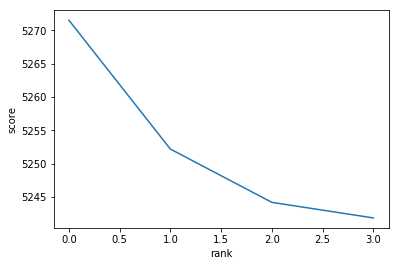

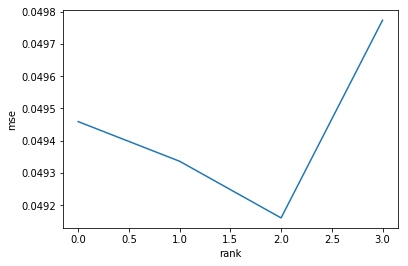

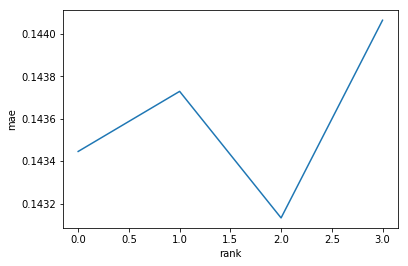

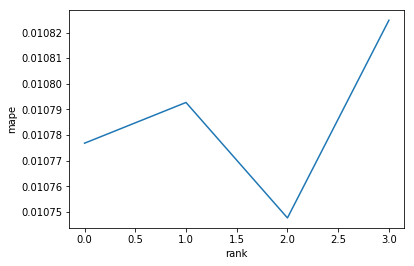

In [33]:
for name in metrics:
    plt.plot(df_gsearch_results[name])
    plt.xlabel('rank'); plt.ylabel(name); plt.show()

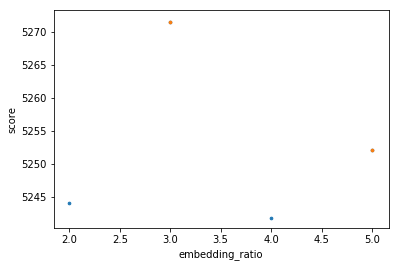

In [34]:
for p in params_gsearch.keys():
    plt.scatter(df_gsearch_results[p], df_gsearch_results['score'], s=7)
    plt.scatter(df_gsearch_results[p][:2], df_gsearch_results['score'][:2], s=7)
    plt.xlabel(p); plt.ylabel('score'); plt.show()

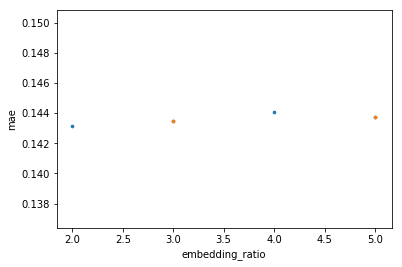

In [46]:
for p in params_gsearch.keys():
    plt.scatter(df_gsearch_results[p], df_gsearch_results['mae'], s=7)
    plt.scatter(df_gsearch_results[p][:2], df_gsearch_results['mae'][:2], s=7)
    plt.xlabel(p); plt.ylabel('mae'); plt.show()

#### Hist

params: {'embedding_ratio': 3, 'epochs': 500, 'batch_norm': True, 'loss': 'mse', 'batch_size': 256, 'n_neurons': (2180, 2180, 1090, 1090, 545, 545)}


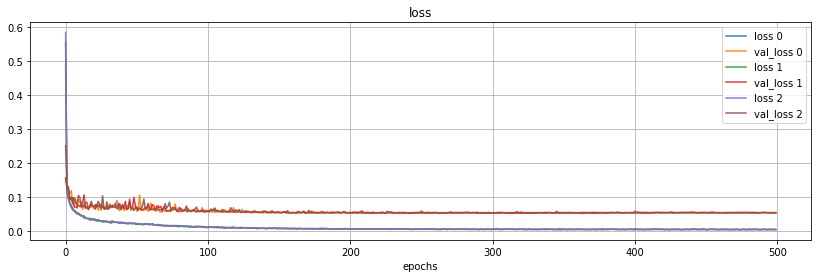

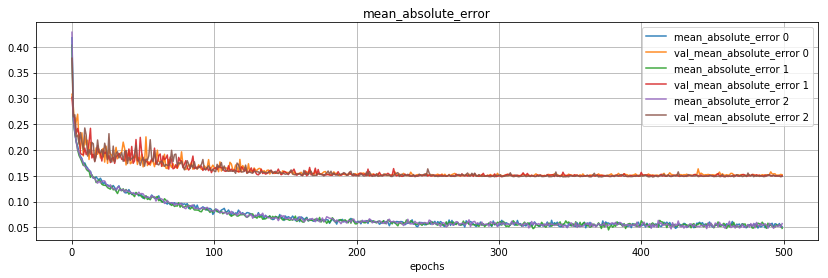

params: {'embedding_ratio': 5, 'epochs': 500, 'batch_norm': True, 'loss': 'mse', 'batch_size': 256, 'n_neurons': (2180, 2180, 1090, 1090, 545, 545)}


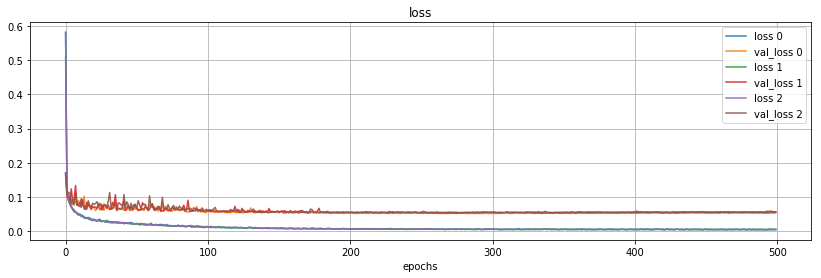

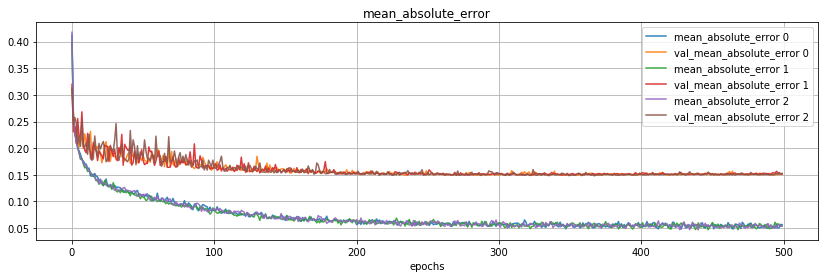

params: {'embedding_ratio': 2, 'epochs': 500, 'batch_norm': True, 'loss': 'mse', 'batch_size': 256, 'n_neurons': (2180, 2180, 1090, 1090, 545, 545)}


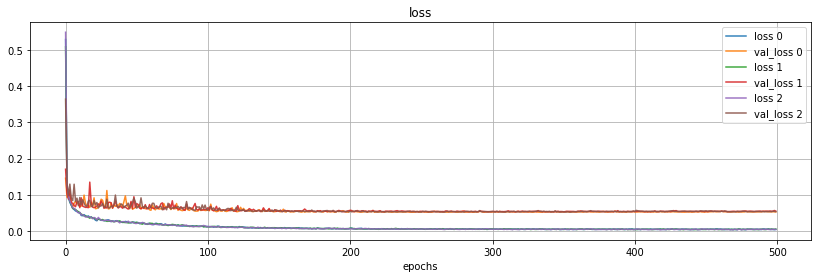

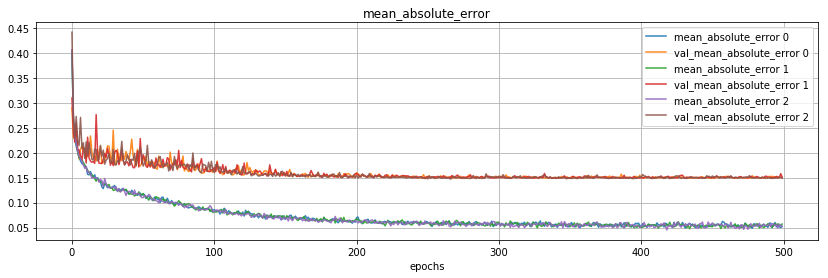

params: {'embedding_ratio': 4, 'epochs': 500, 'batch_norm': True, 'loss': 'mse', 'batch_size': 256, 'n_neurons': (2180, 2180, 1090, 1090, 545, 545)}


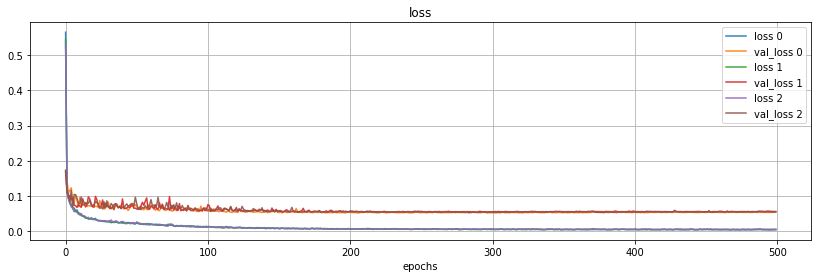

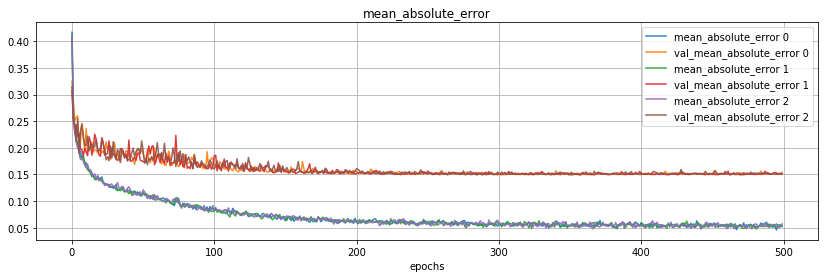

In [48]:
for result, hists in zip(gsearch_results_show, df_gsearch_results['history']):
    print('params:', dict(result[0]))
    plot_list_hist(hists)

params: {'embedding_ratio': 3, 'epochs': 500, 'batch_norm': True, 'loss': 'mse', 'batch_size': 256, 'n_neurons': (2180, 2180, 1090, 1090, 545, 545)}


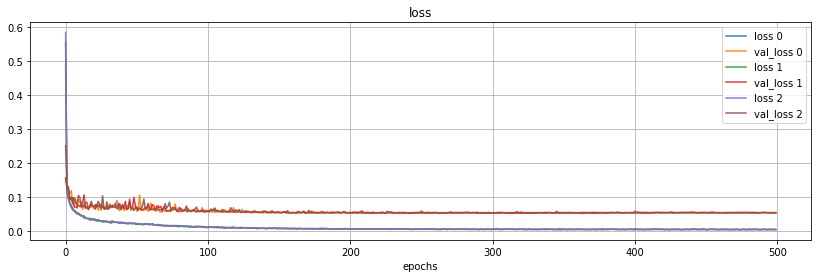

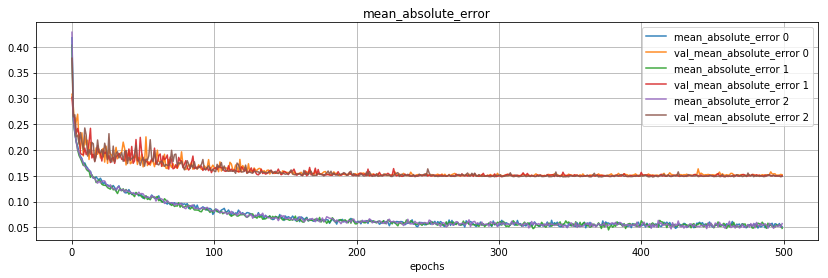

params: {'embedding_ratio': 5, 'epochs': 500, 'batch_norm': True, 'loss': 'mse', 'batch_size': 256, 'n_neurons': (2180, 2180, 1090, 1090, 545, 545)}


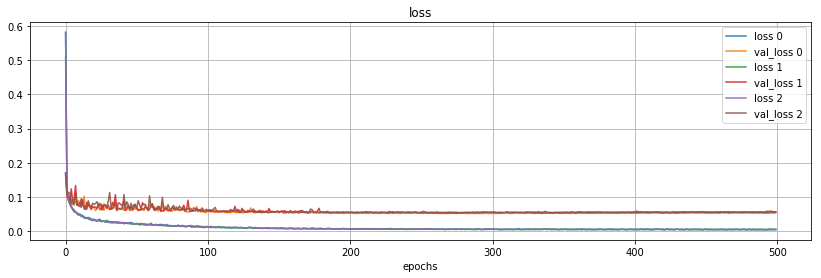

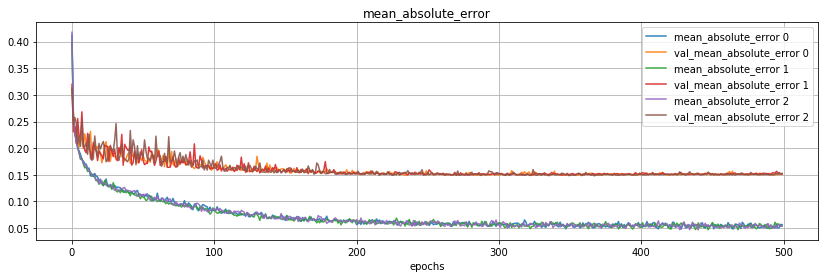

params: {'embedding_ratio': 2, 'epochs': 500, 'batch_norm': True, 'loss': 'mse', 'batch_size': 256, 'n_neurons': (2180, 2180, 1090, 1090, 545, 545)}


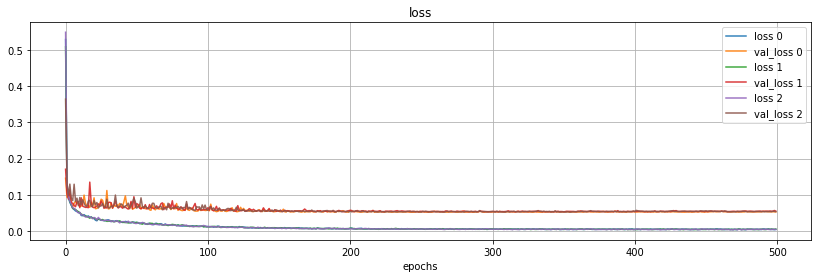

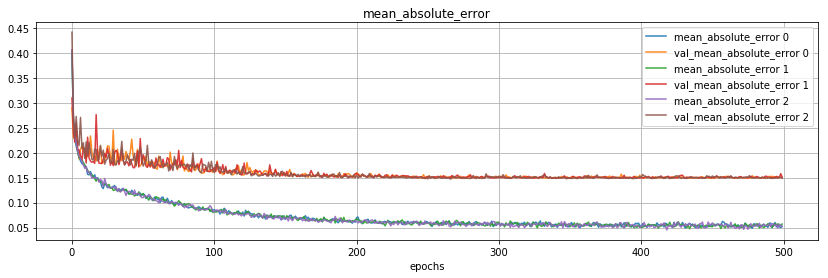

params: {'embedding_ratio': 4, 'epochs': 500, 'batch_norm': True, 'loss': 'mse', 'batch_size': 256, 'n_neurons': (2180, 2180, 1090, 1090, 545, 545)}


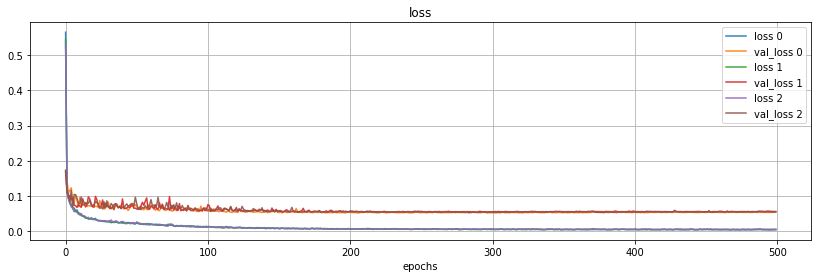

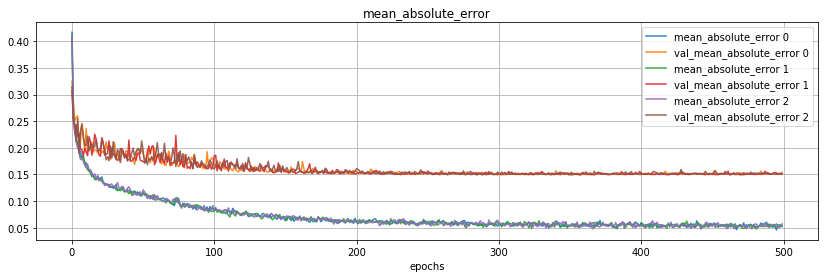

In [49]:
for result, hists in zip(gsearch_results_show, df_gsearch_results['history']):
    print('params:', dict(result[0]))
    plot_list_hist(hists)

params: {'embedding_ratio': 3, 'epochs': 500, 'batch_norm': True, 'loss': 'mse', 'batch_size': 256, 'n_neurons': (2180, 2180, 1090, 1090, 545, 545)}


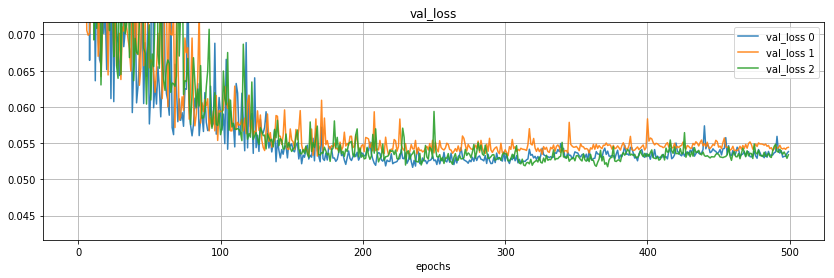

params: {'embedding_ratio': 5, 'epochs': 500, 'batch_norm': True, 'loss': 'mse', 'batch_size': 256, 'n_neurons': (2180, 2180, 1090, 1090, 545, 545)}


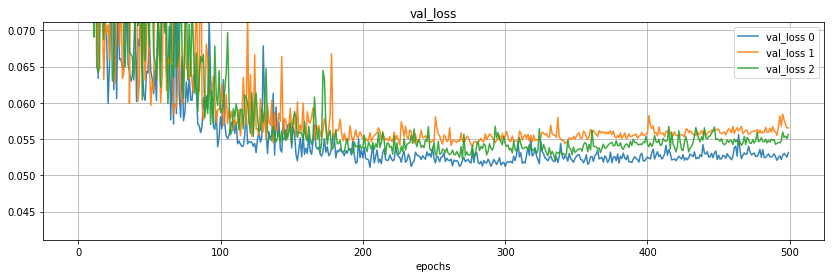

params: {'embedding_ratio': 2, 'epochs': 500, 'batch_norm': True, 'loss': 'mse', 'batch_size': 256, 'n_neurons': (2180, 2180, 1090, 1090, 545, 545)}


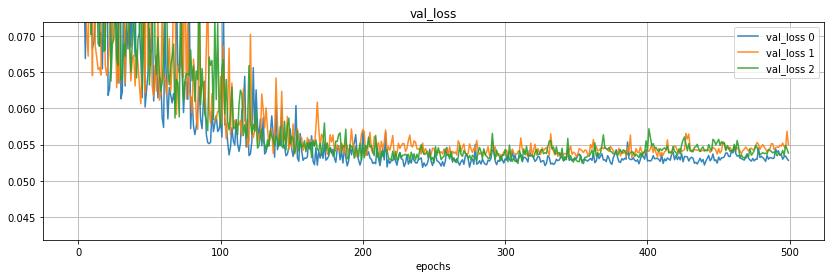

params: {'embedding_ratio': 4, 'epochs': 500, 'batch_norm': True, 'loss': 'mse', 'batch_size': 256, 'n_neurons': (2180, 2180, 1090, 1090, 545, 545)}


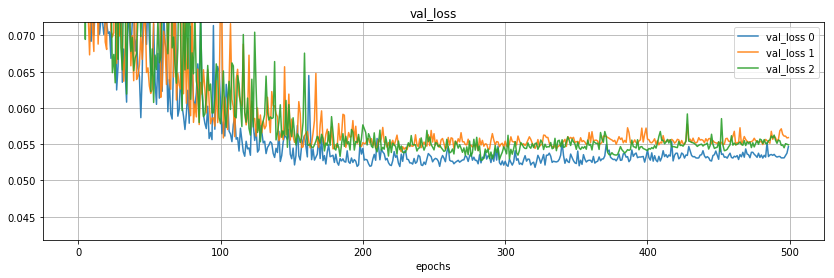

In [50]:
for result, hists in zip(gsearch_results_show, df_gsearch_results['history']):
    print('params:', dict(result[0]))
    plot_list_hist(hists, ylim=(min(hists[0]['val_loss'])-0.01, 
                                min(hists[0]['val_loss'])+0.02), metrics_plot=['val_loss'])

params: {'embedding_ratio': 3, 'epochs': 500, 'batch_norm': True, 'loss': 'mse', 'batch_size': 256, 'n_neurons': (2180, 2180, 1090, 1090, 545, 545)}


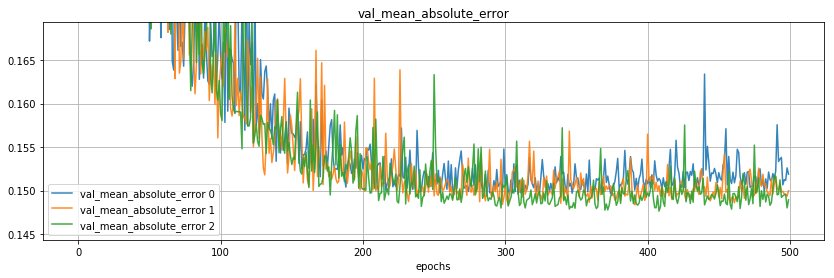

params: {'embedding_ratio': 5, 'epochs': 500, 'batch_norm': True, 'loss': 'mse', 'batch_size': 256, 'n_neurons': (2180, 2180, 1090, 1090, 545, 545)}


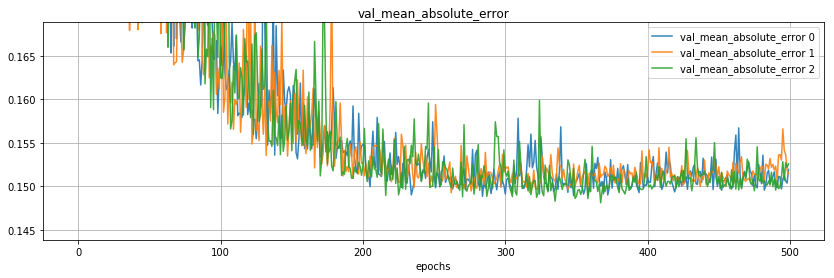

params: {'embedding_ratio': 2, 'epochs': 500, 'batch_norm': True, 'loss': 'mse', 'batch_size': 256, 'n_neurons': (2180, 2180, 1090, 1090, 545, 545)}


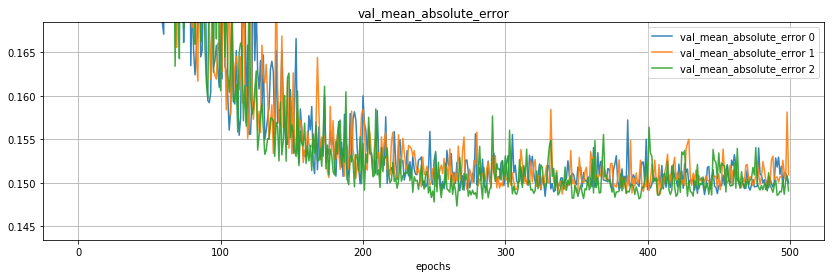

params: {'embedding_ratio': 4, 'epochs': 500, 'batch_norm': True, 'loss': 'mse', 'batch_size': 256, 'n_neurons': (2180, 2180, 1090, 1090, 545, 545)}


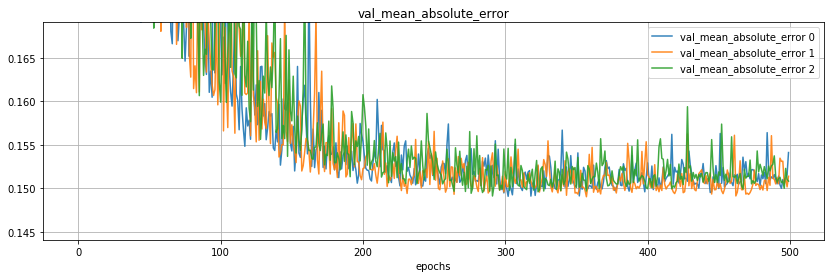

In [51]:
for result, hists in zip(gsearch_results_show, df_gsearch_results['history']):
    print('params:', dict(result[0]))
    plot_list_hist(hists, ylim=(min(hists[0]['val_mean_absolute_error'])-0.005, 
                                min(hists[0]['val_mean_absolute_error'])+0.02), metrics_plot=['val_mean_absolute_error'])

params: {'embedding_ratio': 3, 'epochs': 500, 'batch_norm': True, 'loss': 'mse', 'batch_size': 256, 'n_neurons': (2180, 2180, 1090, 1090, 545, 545)}


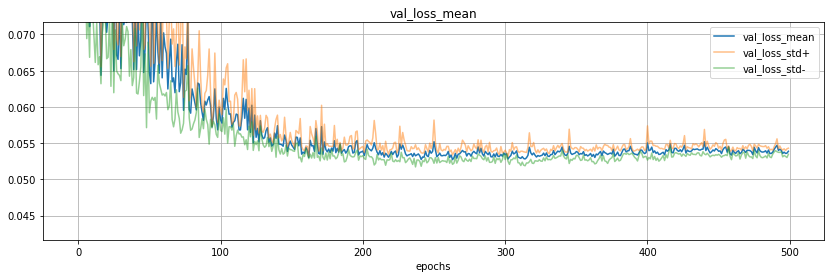

params: {'embedding_ratio': 5, 'epochs': 500, 'batch_norm': True, 'loss': 'mse', 'batch_size': 256, 'n_neurons': (2180, 2180, 1090, 1090, 545, 545)}


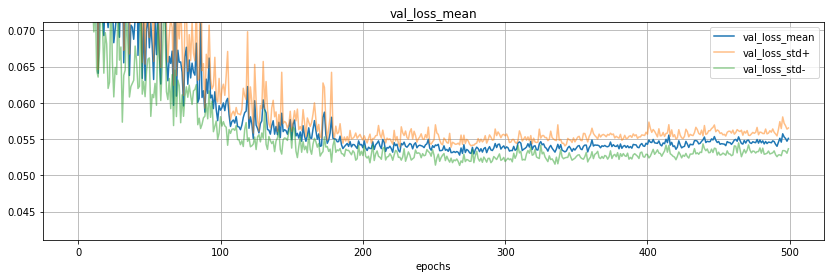

params: {'embedding_ratio': 2, 'epochs': 500, 'batch_norm': True, 'loss': 'mse', 'batch_size': 256, 'n_neurons': (2180, 2180, 1090, 1090, 545, 545)}


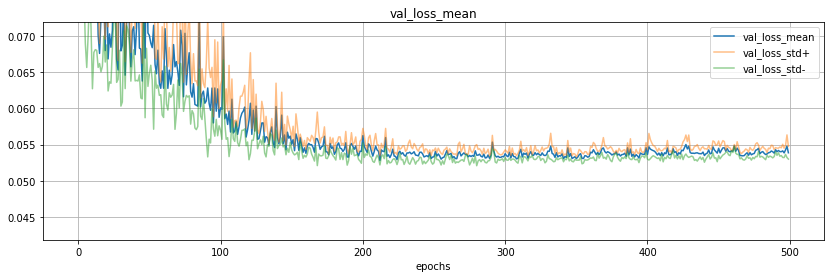

params: {'embedding_ratio': 4, 'epochs': 500, 'batch_norm': True, 'loss': 'mse', 'batch_size': 256, 'n_neurons': (2180, 2180, 1090, 1090, 545, 545)}


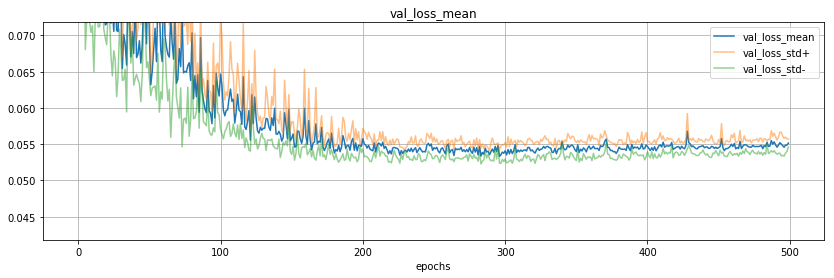

In [52]:
for result, hists in zip(gsearch_results_show, df_gsearch_results['history']):
    print('params:', dict(result[0]))
    plot_list_hist_mean(hists, ylim=(min(hists[0]['val_loss'])-0.01, 
                                     min(hists[0]['val_loss'])+0.02), metrics_plot=['val_loss'])

params: {'embedding_ratio': 3, 'epochs': 500, 'batch_norm': True, 'loss': 'mse', 'batch_size': 256, 'n_neurons': (2180, 2180, 1090, 1090, 545, 545)}


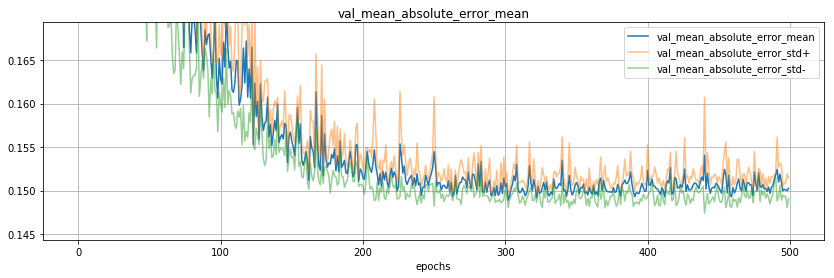

params: {'embedding_ratio': 5, 'epochs': 500, 'batch_norm': True, 'loss': 'mse', 'batch_size': 256, 'n_neurons': (2180, 2180, 1090, 1090, 545, 545)}


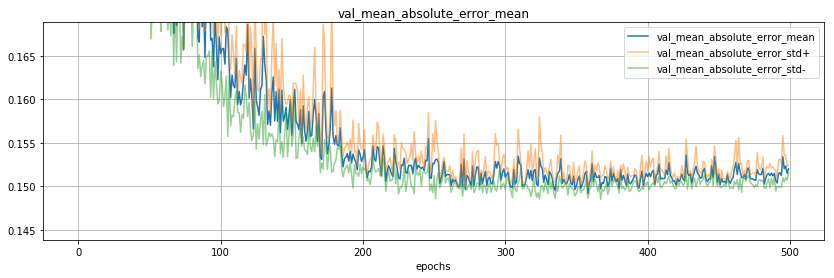

params: {'embedding_ratio': 2, 'epochs': 500, 'batch_norm': True, 'loss': 'mse', 'batch_size': 256, 'n_neurons': (2180, 2180, 1090, 1090, 545, 545)}


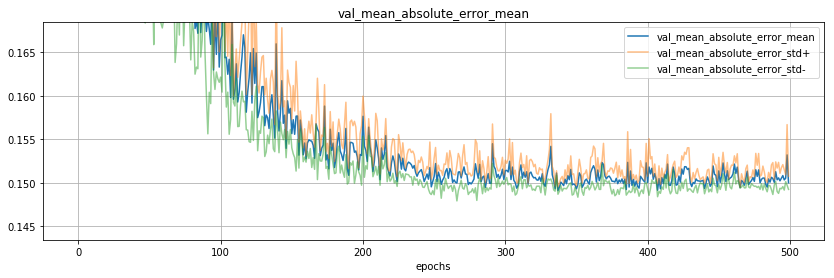

params: {'embedding_ratio': 4, 'epochs': 500, 'batch_norm': True, 'loss': 'mse', 'batch_size': 256, 'n_neurons': (2180, 2180, 1090, 1090, 545, 545)}


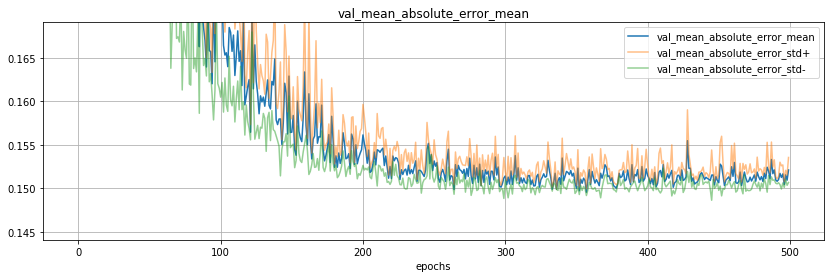

In [53]:
for result, hists in zip(gsearch_results_show, df_gsearch_results['history']):
    print('params:', dict(result[0]))
    plot_list_hist_mean(hists, ylim=(min(hists[0]['val_mean_absolute_error'])-0.005, 
                                     min(hists[0]['val_mean_absolute_error'])+0.02), metrics_plot=['val_mean_absolute_error'])

#### Mean scores

In [42]:
df_gsearch_results.check()

,score,mse,mae,mape,batch_norm,batch_size,best_iterations,embedding_ratio,epochs,loss,mean_best_iterations,n_neurons,history,mean_mse_nn,mean_mae_nn,std_mse_nn,std_mae_nn
0,5271.515984,0.049459,0.143446,0.010777,True,256,"[288, 392, 409]",3,500,mse,363,"(2180, 2180, 1090, 1090, 545, 545)","[{'loss': [0.5542073615550995, 0.1204620158433...",0.053447,0.150641,0.000986,0.000418
1,5252.182796,0.049337,0.143729,0.010793,True,256,"[285, 263, 368]",5,500,mse,305,"(2180, 2180, 1090, 1090, 545, 545)","[{'loss': [0.5819491271018982, 0.1180755200386...",0.053428,0.149926,0.001153,0.000416
2,5244.183824,0.049161,0.143132,0.010748,True,256,"[329, 408, 267]",2,500,mse,335,"(2180, 2180, 1090, 1090, 545, 545)","[{'loss': [0.5283503200650215, 0.1162520815968...",0.053672,0.150288,0.001036,0.001092
3,5241.847351,0.049773,0.144064,0.010825,True,256,"[303, 358, 292]",4,500,mse,318,"(2180, 2180, 1090, 1090, 545, 545)","[{'loss': [0.5648952144145966, 0.1233129028081...",0.054528,0.151485,0.001269,0.000637


shape = (4, 17)


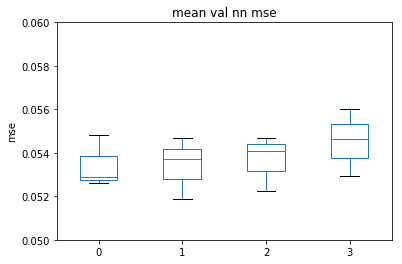

In [43]:
pd.DataFrame([
    [hist['val_loss'][epoch-1] for hist in hists]
    for hists, epoch 
    in zip(df_gsearch_results['history'], df_gsearch_results['mean_best_iterations'])
]).T.plot.box(ylim=(0.05, 0.06), title='mean val nn mse'); plt.ylabel('mse'); plt.show()

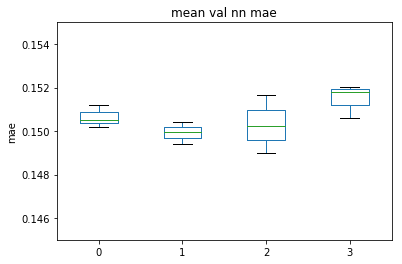

In [55]:
pd.DataFrame([
    [hist['val_mean_absolute_error'][epoch-1] for hist in hists]
    for hists, epoch 
    in zip(df_gsearch_results['history'], df_gsearch_results['mean_best_iterations'])
]).T.plot.box(ylim=(0.145, 0.155), title='mean val nn mae'); plt.ylabel('mae'); plt.show()

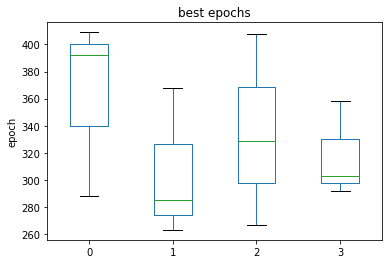

In [45]:
pd.DataFrame([
    row for row in df_gsearch_results['best_iterations']
]).T.plot.box(title='best epochs'); plt.ylabel('epoch'); plt.show()

### Result